In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# --- Unzip the dataset ---
# IMPORTANT: Update this path to match the location of your zip file in Drive.
zip_path = '/content/drive/MyDrive/ColabNotebooks/Vision/diffusionProject/ffhq256_10ksubset.zip'

# The destination folder in the local Colab environment.
destination_path = '/content'

print("Unzipping dataset...")
# The -q flag makes the output cleaner (quiet mode)
!unzip -q {zip_path} -d {destination_path}

print(f"✅ Dataset unzipped to {destination_path}")

Unzipping dataset...
✅ Dataset unzipped to /content


In [ ]:
# Install
!pip install pytorch_wavelets torchmetrics lpips torch-fidelity

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.9/54.9 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.9/981.9 kB 19.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 125.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 93.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 56.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 38.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torch.optim as optim
import torch._dynamo
from torch.utils.data import Dataset, DataLoader, Subset
from torch.nn.utils import spectral_norm
from torchvision.utils import save_image, make_grid
from torchvision import transforms
from PIL import Image
import time
import random
import math
from tqdm.auto import tqdm
from tqdm.autonotebook import tqdm
import os
import glob
import matplotlib.pyplot as plt

import torchmetrics
from torchmetrics.image.fid import FrechetInceptionDistance
import lpips

import torch.fft
from pytorch_wavelets import DWTForward
from einops import rearrange

# Enable TensorFloat32
torch.set_float32_matmul_precision('high')

# --- Configuration & Hyperparameters ---

# Set the path to your image folder in Google Drive
# IMPORTANT: Update this path to match where you saved your dataset.
DATASET_PATH = '/content/ffhq_subset_10k'
NUM_IMAGES_TO_USE_CNN = 10000
NUM_IMAGES_TO_USE_DIFFUSION = 1000

# Training settings
NUM_EPOCHS_CNN = 40
NUM_EPOCHS_DIFFUSION = 100
LEARNING_RATE = 1e-4
BATCH_SIZE = 4

# Set the device (use GPU if available)
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {DEVICE}")

Using device: cuda


In [ ]:
class FFHQDataset(Dataset):
    """Custom PyTorch Dataset for loading FFHQ images."""
    def __init__(self, img_dir, transform=None, num_images=None): # Add num_images parameter
        """
        Args:
            img_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied on a sample.
            num_images (int, optional): Number of images to use. If None, use all images.
        """
        # Find all files with .png or .jpg extension
        self.img_paths = glob.glob(os.path.join(img_dir, '*.png'))
        self.img_paths.extend(glob.glob(os.path.join(img_dir, '*.jpg')))
        self.transform = transform

        if num_images:
            # If a number is specified, shuffle all paths and take a random subset
            random.shuffle(self.img_paths)
            self.img_paths = self.img_paths[:num_images]

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image

# Your transform definition remains the same
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

In [ ]:
def tensor_to_image(tensor):
    """
    Converts a PyTorch tensor to a displayable NumPy image.
    It denormalizes, moves to CPU, and changes dimension order.
    """
    # Denormalize the image from [-1, 1] to [0, 1]
    image = tensor * 0.5 + 0.5
    # Move tensor to CPU and convert to NumPy array
    image = image.cpu().numpy()
    # Transpose dimensions from (C, H, W) to (H, W, C) for plotting
    image = image.transpose(1, 2, 0)
    # Clip values to be in the valid [0, 1] range for images
    image = np.clip(image, 0, 1)
    return image

In [ ]:
def create_mask(image, mask_percentage=0.025):
    """
    Creates masks that are more likely to cover facial features.
    """
    batch_size, _, height, width = image.shape
    mask = torch.ones_like(image)

    # Face regions typically in center 60% of image
    center_bias = 0.3  # 30% border on each side

    for i in range(batch_size):
        mask_h = int(np.sqrt(height * width * mask_percentage))
        mask_w = mask_h

        # Bias towards center
        top_min = int(height * center_bias)
        top_max = int(height * (1 - center_bias)) - mask_h
        left_min = int(width * center_bias)
        left_max = int(width * (1 - center_bias)) - mask_w

        top = np.random.randint(top_min, max(top_min + 1, top_max))
        left = np.random.randint(left_min, max(left_min + 1, left_max))

        mask[i, :, top:top+mask_h, left:left+mask_w] = 0

    masked_image = image * mask
    return masked_image, mask

In [ ]:
class SelfAttention(nn.Module):
    """ A simple self-attention layer """
    def __init__(self, channels):
        super().__init__()
        self.query = nn.Conv2d(channels, channels // 8, 1)
        self.key   = nn.Conv2d(channels, channels // 8, 1)
        self.value = nn.Conv2d(channels, channels, 1)
        self.gamma = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        batch_size, C, width, height = x.size()
        q = self.query(x).view(batch_size, -1, width * height).permute(0, 2, 1)
        k = self.key(x).view(batch_size, -1, width * height)
        v = self.value(x).view(batch_size, -1, width * height)

        attention_map = F.softmax(torch.bmm(q, k), dim=-1)

        out = torch.bmm(v, attention_map.permute(0, 2, 1))
        out = out.view(batch_size, C, width, height)

        return self.gamma * out + x # Add skip connection

class UpsampleBlock(nn.Module):
    """An upsampling block using Conv2d and PixelShuffle."""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        # The Conv2d layer produces 4x the channels for a 2x upscale
        self.conv = nn.Conv2d(in_channels, out_channels * 4, kernel_size=3, padding=1)
        self.pixel_shuffle = nn.PixelShuffle(2) # Rearranges channels to upscale by 2x
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        return self.relu(self.pixel_shuffle(self.conv(x)))

class GatedConv2d(nn.Module):
    """
    A Gated Convolutional Layer.
    It learns a dynamic feature mask for each channel at every location.
    """
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1):
        super().__init__()
        # Convolution for the features
        self.conv_feature = nn.Conv2d(
            in_channels, out_channels, kernel_size, stride, padding, dilation
        )
        # Convolution for the gating mechanism
        self.conv_gate = nn.Conv2d(
            in_channels, out_channels, kernel_size, stride, padding, dilation
        )

    def forward(self, x):
        # Get the features and the gate
        features = self.conv_feature(x)
        gate = torch.sigmoid(self.conv_gate(x)) # Gate values are between 0 and 1

        # Element-wise multiplication to apply the learned gate
        return features * gate

class GatedResidualBlock(nn.Module):
    """A Residual Block that uses Gated Convolutions."""
    def __init__(self, channels, dilation=1):
        super().__init__()
        padding = dilation

        # Replace nn.Conv2d with GatedConv2d
        self.conv1 = GatedConv2d(channels, channels, kernel_size=3, padding=padding, dilation=dilation)
        self.bn1 = nn.BatchNorm2d(channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = GatedConv2d(channels, channels, kernel_size=3, padding=padding, dilation=dilation)
        self.bn2 = nn.BatchNorm2d(channels)

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = out + residual  # Residual connection
        out = self.relu(out)
        return out

class UNetSR(nn.Module):
    """
    A U-Net architecture with corrected channel dimensions for the decoder.
    """
    def __init__(self, in_channels=4, out_channels=3, num_channels=64):
        super().__init__()

        # --- Initial Convolution ---
        self.init_conv = nn.Conv2d(in_channels, num_channels, kernel_size=3, padding=1)

        # --- Encoder Path ---
        self.enc1 = GatedResidualBlock(num_channels, dilation=1)
        self.enc2 = GatedResidualBlock(num_channels, dilation=1)
        self.pool = nn.MaxPool2d(2)

        # --- Bottleneck with Dilation and Attention ---
        self.bottleneck = nn.Sequential(
            GatedResidualBlock(num_channels, dilation=2),
            # SelfAttention(num_channels), # Add attention layer
            GatedResidualBlock(num_channels, dilation=4)
        )

        # --- Decoder Path ---
        self.upconv2 = UpsampleBlock(num_channels, num_channels)
        # Input channels = upsampled (64) + skip connection from e2 (64) = 128
        self.dec2 = GatedResidualBlock(num_channels * 2, dilation=1)

        self.upconv1 = UpsampleBlock(num_channels * 2, num_channels)
        # Input channels = upsampled (64) + skip connection from e1 (64) = 128
        self.dec1 = GatedResidualBlock(num_channels * 2, dilation=1)

        # --- Final Output Layer ---
        # The input to this layer comes from dec1, which outputs 128 channels.
        self.out_conv = nn.Conv2d(num_channels * 2, out_channels, kernel_size=3, padding=1)

    def forward(self, x):
        # Initial feature extraction
        x0 = self.init_conv(x)

        # Encoder
        e1 = self.enc1(x0)
        p1 = self.pool(e1)

        e2 = self.enc2(p1)
        p2 = self.pool(e2)

        # Bottleneck
        b = self.bottleneck(p2)

        # Decoder with Skip Connections
        d2 = self.upconv2(b)
        d2 = torch.cat([d2, e2], dim=1)
        d2 = self.dec2(d2)

        d1 = self.upconv1(d2)
        d1 = torch.cat([d1, e1], dim=1)
        d1 = self.dec1(d1)

        # Final Output
        out = self.out_conv(d1)

        return torch.tanh(out)

In [ ]:
# --- 1. Create the main dataset ---
# This should use the LARGER number of images you intend to work with.
# Let's assume NUM_IMAGES_TO_USE_CNN is the total pool of images.
print("Creating the main dataset...")
full_dataset = FFHQDataset(
    img_dir=DATASET_PATH,
    transform=transform,
    num_images=NUM_IMAGES_TO_USE_CNN # Use the total number of images available for the experiment
)
print(f"✅ Main dataset created with {len(full_dataset)} images.")

# --- 2. Split the dataset into Training, Validation, and Test sets ---
print("\nSplitting data into training, validation, and test sets...")
dataset_size = len(full_dataset)
indices = list(range(dataset_size))
np.random.seed(42) # for reproducibility
np.random.shuffle(indices)

# Define split points for an 80/10/10 split
train_split = int(np.floor(0.8 * dataset_size))
val_split = int(np.floor(0.9 * dataset_size))

# Create indices for each set
train_indices = indices[:train_split]
val_indices = indices[train_split:val_split]
test_indices = indices[val_split:]

# Create PyTorch Subsets
train_data = Subset(full_dataset, train_indices)
val_data = Subset(full_dataset, val_indices)
test_data = Subset(full_dataset, test_indices)

print(f"✅ Training set size: {len(train_data)}")
print(f"✅ Validation set size: {len(val_data)}")
print(f"✅ Test set size: {len(test_data)}")

# --- 3. Create the Diffusion Model's training subset ---
# This should be a subset of the TRAINING data.
print("\nCreating a subset of the training data for the diffusion model...")
diffusion_indices = train_indices[:NUM_IMAGES_TO_USE_DIFFUSION] # Take from the start of shuffled train indices
diffusion_data = Subset(full_dataset, diffusion_indices)
print(f"✅ Diffusion training set size: {len(diffusion_data)}")


# --- 4. Create DataLoaders for each set ---
print("\nCreating DataLoaders...")
# The main CNN will now train on the 'train_data' subset
cnn_dataloader = DataLoader(
    train_data,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=4,
    pin_memory=True
)
# New DataLoader for validation
val_dataloader = DataLoader(
    val_data,
    batch_size=BATCH_SIZE,
    shuffle=False, # No need to shuffle validation data
    num_workers=4,
    pin_memory=True
)
# New DataLoader for testing
test_dataloader = DataLoader(
    test_data,
    batch_size=BATCH_SIZE,
    shuffle=False, # No need to shuffle test data
    num_workers=4,
    pin_memory=True
)
# Diffusion DataLoader uses its own subset of the training data
diffusion_dataloader = DataLoader(
    diffusion_data,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=4,
    drop_last=True,
    pin_memory=True
)
print("✅ All DataLoaders created.")

# --- 5. Initialize models and optimizers (unchanged) ---
print("\nInitializing models and optimizers...")
cnn_model = UNetSR().to(DEVICE)
diffusion_model = DiffusionUNet(
    in_channels=3,
    model_channels=32,  # default: 64
    time_emb_dim=128    # default: 256
).to(DEVICE)

# Compile the models for a speed boost
cnn_model = torch.compile(cnn_model)
diffusion_model = torch.compile(diffusion_model, dynamic=True)

# Initialize optimizers
optimizer_cnn = optim.Adam(cnn_model.parameters(), lr=LEARNING_RATE)
optimizer_diffusion = torch.optim.Adam(diffusion_model.parameters(), lr=1e-5)

print("\nSetup complete. Ready for training!")

Creating the main dataset...
✅ Main dataset created with 10000 images.

Splitting data into training, validation, and test sets...
✅ Training set size: 8000
✅ Validation set size: 1000
✅ Test set size: 1000

Creating a subset of the training data for the diffusion model...
✅ Diffusion training set size: 1000

Creating DataLoaders...
✅ All DataLoaders created.

Initializing models and optimizers...

Setup complete. Ready for training!


In [ ]:
# --- Stage 1: Pre-train the CNN ---
print("--- Stage 1: Pre-training CNN ---")

ACCUMULATION_STEPS = 4
WARMUP_EPOCHS = 5
best_val_loss = float('inf')

# Initialize the DWT transform
dwt = DWTForward(J=1, mode='zero', wave='haar').to(DEVICE)
alpha = 0.1  # Weight for FFT Loss
beta = 0.1   # Weight for DWT Loss

# Add scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_cnn, mode='min', factor=0.5, patience=10
)

# Initialize a Gradient Scaler for the 'cuda' device
scaler = torch.amp.GradScaler('cuda')

for epoch in tqdm(range(NUM_EPOCHS_CNN), desc="CNN Epochs"):
    cnn_model.train()
    epoch_losses = []

    for i, batch in enumerate(cnn_dataloader):
        original_image = batch.to(DEVICE)
        masked_image, mask = create_mask(original_image)
        mask = mask.to(DEVICE)

        # --- Part 1: Run the main CNN in Mixed Precision for speed ---
        with torch.amp.autocast('cuda'):
            cnn_input = torch.cat((masked_image, mask[:, 0:1, :, :]), dim=1)
            coarse_inpainting = cnn_model(cnn_input)

            # --- Spatial Domain Loss (can stay in autocast) ---
            hole_mask = 1 - mask
            valid_loss = nn.functional.l1_loss(
                coarse_inpainting * mask,
                original_image * mask,
                reduction='sum'
            ) / mask.sum().clamp(min=1)

            hole_loss = 10 * nn.functional.l1_loss(
                coarse_inpainting * hole_mask,
                original_image * hole_mask,
                reduction='sum'
            ) / hole_mask.sum().clamp(min=1)

            l1_loss = valid_loss + hole_loss

        # --- Part 2: Calculate sensitive losses in Full Precision (float32) ---
        # Explicitly cast the output to float32 before FFT and DWT
        coarse_inpainting_fp32 = coarse_inpainting.float()

        if epoch < WARMUP_EPOCHS:
            loss = l1_loss
        else:
            # --- FFT Loss (in float32) ---
            fft_pred = torch.fft.fft2(coarse_inpainting_fp32, dim=(-2, -1))
            fft_gt = torch.fft.fft2(original_image, dim=(-2, -1))
            fft_loss = nn.functional.mse_loss(torch.abs(fft_pred), torch.abs(fft_gt))

            # --- DWT Loss (in float32) ---
            _, Yh_pred = dwt(coarse_inpainting_fp32)
            _, Yh_gt = dwt(original_image)
            dwt_loss = nn.functional.l1_loss(Yh_pred[0], Yh_gt[0])

            # Combine all losses. PyTorch handles the type promotion automatically.
            loss = l1_loss + alpha * fft_loss + beta * dwt_loss

        # --- Backpropagation (unchanged) ---
        loss = loss / ACCUMULATION_STEPS
        scaler.scale(loss).backward()

        if (i + 1) % ACCUMULATION_STEPS == 0:
            scaler.step(optimizer_cnn)
            scaler.update()
            optimizer_cnn.zero_grad()

        epoch_losses.append(loss.item() * ACCUMULATION_STEPS)

    avg_train_loss = np.mean(epoch_losses)
    print(f"\nEpoch {epoch}: Train Loss = {avg_train_loss:.4f}")

print("✅ CNN Pre-training Complete.")
torch.save(cnn_model.state_dict(), 'final_cnn_model.pth')

--- Stage 1: Pre-training CNN ---


CNN Epochs:   0%|          | 0/40 [00:00<?, ?it/s]


Epoch 0: Train Loss = 2.0540

Epoch 1: Train Loss = 1.5206

Epoch 2: Train Loss = 1.4101

Epoch 3: Train Loss = 1.3351

Epoch 4: Train Loss = 1.2914

Epoch 5: Train Loss = 19.8947

Epoch 6: Train Loss = 8.5459

Epoch 7: Train Loss = 6.9039

Epoch 8: Train Loss = 6.0957

Epoch 9: Train Loss = 5.5472

Epoch 10: Train Loss = 5.3007

Epoch 11: Train Loss = 4.9328

Epoch 12: Train Loss = 4.7227

Epoch 13: Train Loss = 4.5253

Epoch 14: Train Loss = 4.3783

Epoch 15: Train Loss = 4.2534

Epoch 16: Train Loss = 4.1426

Epoch 17: Train Loss = 4.1062

Epoch 18: Train Loss = 3.9623

Epoch 19: Train Loss = 3.8764

Epoch 20: Train Loss = 3.8018

Epoch 21: Train Loss = 3.7479

Epoch 22: Train Loss = 3.7026

Epoch 23: Train Loss = 3.5530

Epoch 24: Train Loss = 3.5699

Epoch 25: Train Loss = 3.4659

Epoch 26: Train Loss = 3.4068

Epoch 27: Train Loss = 3.4324

Epoch 28: Train Loss = 3.3373

Epoch 29: Train Loss = 3.2836

Epoch 30: Train Loss = 3.3482

Epoch 31: Train Loss = 3.3045

Epoch 32: Train 

--- Evaluating CNN Model ---


/usr/local/lib/python3.11/dist-packages/torchmetrics/utilities/prints.py:62: FutureWarning: Importing `PeakSignalNoiseRatio` from `torchmetrics` was deprecated and will be removed in 2.0. Import `PeakSignalNoiseRatio` from `torchmetrics.image` instead.
  _future_warning(
/usr/local/lib/python3.11/dist-packages/torchmetrics/utilities/prints.py:62: FutureWarning: Importing `StructuralSimilarityIndexMeasure` from `torchmetrics` was deprecated and will be removed in 2.0. Import `StructuralSimilarityIndexMeasure` from `torchmetrics.image` instead.
  _future_warning(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The cu

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 232MB/s]


Loading model from: /usr/local/lib/python3.11/dist-packages/lpips/weights/v0.1/alex.pth


Downloading: "https://github.com/toshas/torch-fidelity/releases/download/v0.2.0/weights-inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/weights-inception-2015-12-05-6726825d.pth
100%|██████████| 91.2M/91.2M [00:02<00:00, 36.3MB/s]

Evaluating on multiple batches...



CNN INPAINTING EVALUATION RESULTS

📊 RECONSTRUCTION METRICS:
  PSNR:  39.67 ± 1.57 dB
  SSIM:  0.9879 ± 0.0052
  MSE:   0.0001 ± 0.0000
  MAE:   0.0037 ± 0.0004

🎨 PERCEPTUAL METRICS:
  LPIPS: 0.0073 ± 0.0025 (lower is better)
  FID:   3.91 (lower is better)

🎯 MASKED REGION METRICS:
  Masked MSE: 0.0119 ± 0.0050
  Masked MAE: 0.1234 ± 0.0215

📈 FREQUENCY DOMAIN ANALYSIS:
  Average Frequency Magnitude Ratio: 0.986
  High-Frequency Recovery Ratio: 0.987


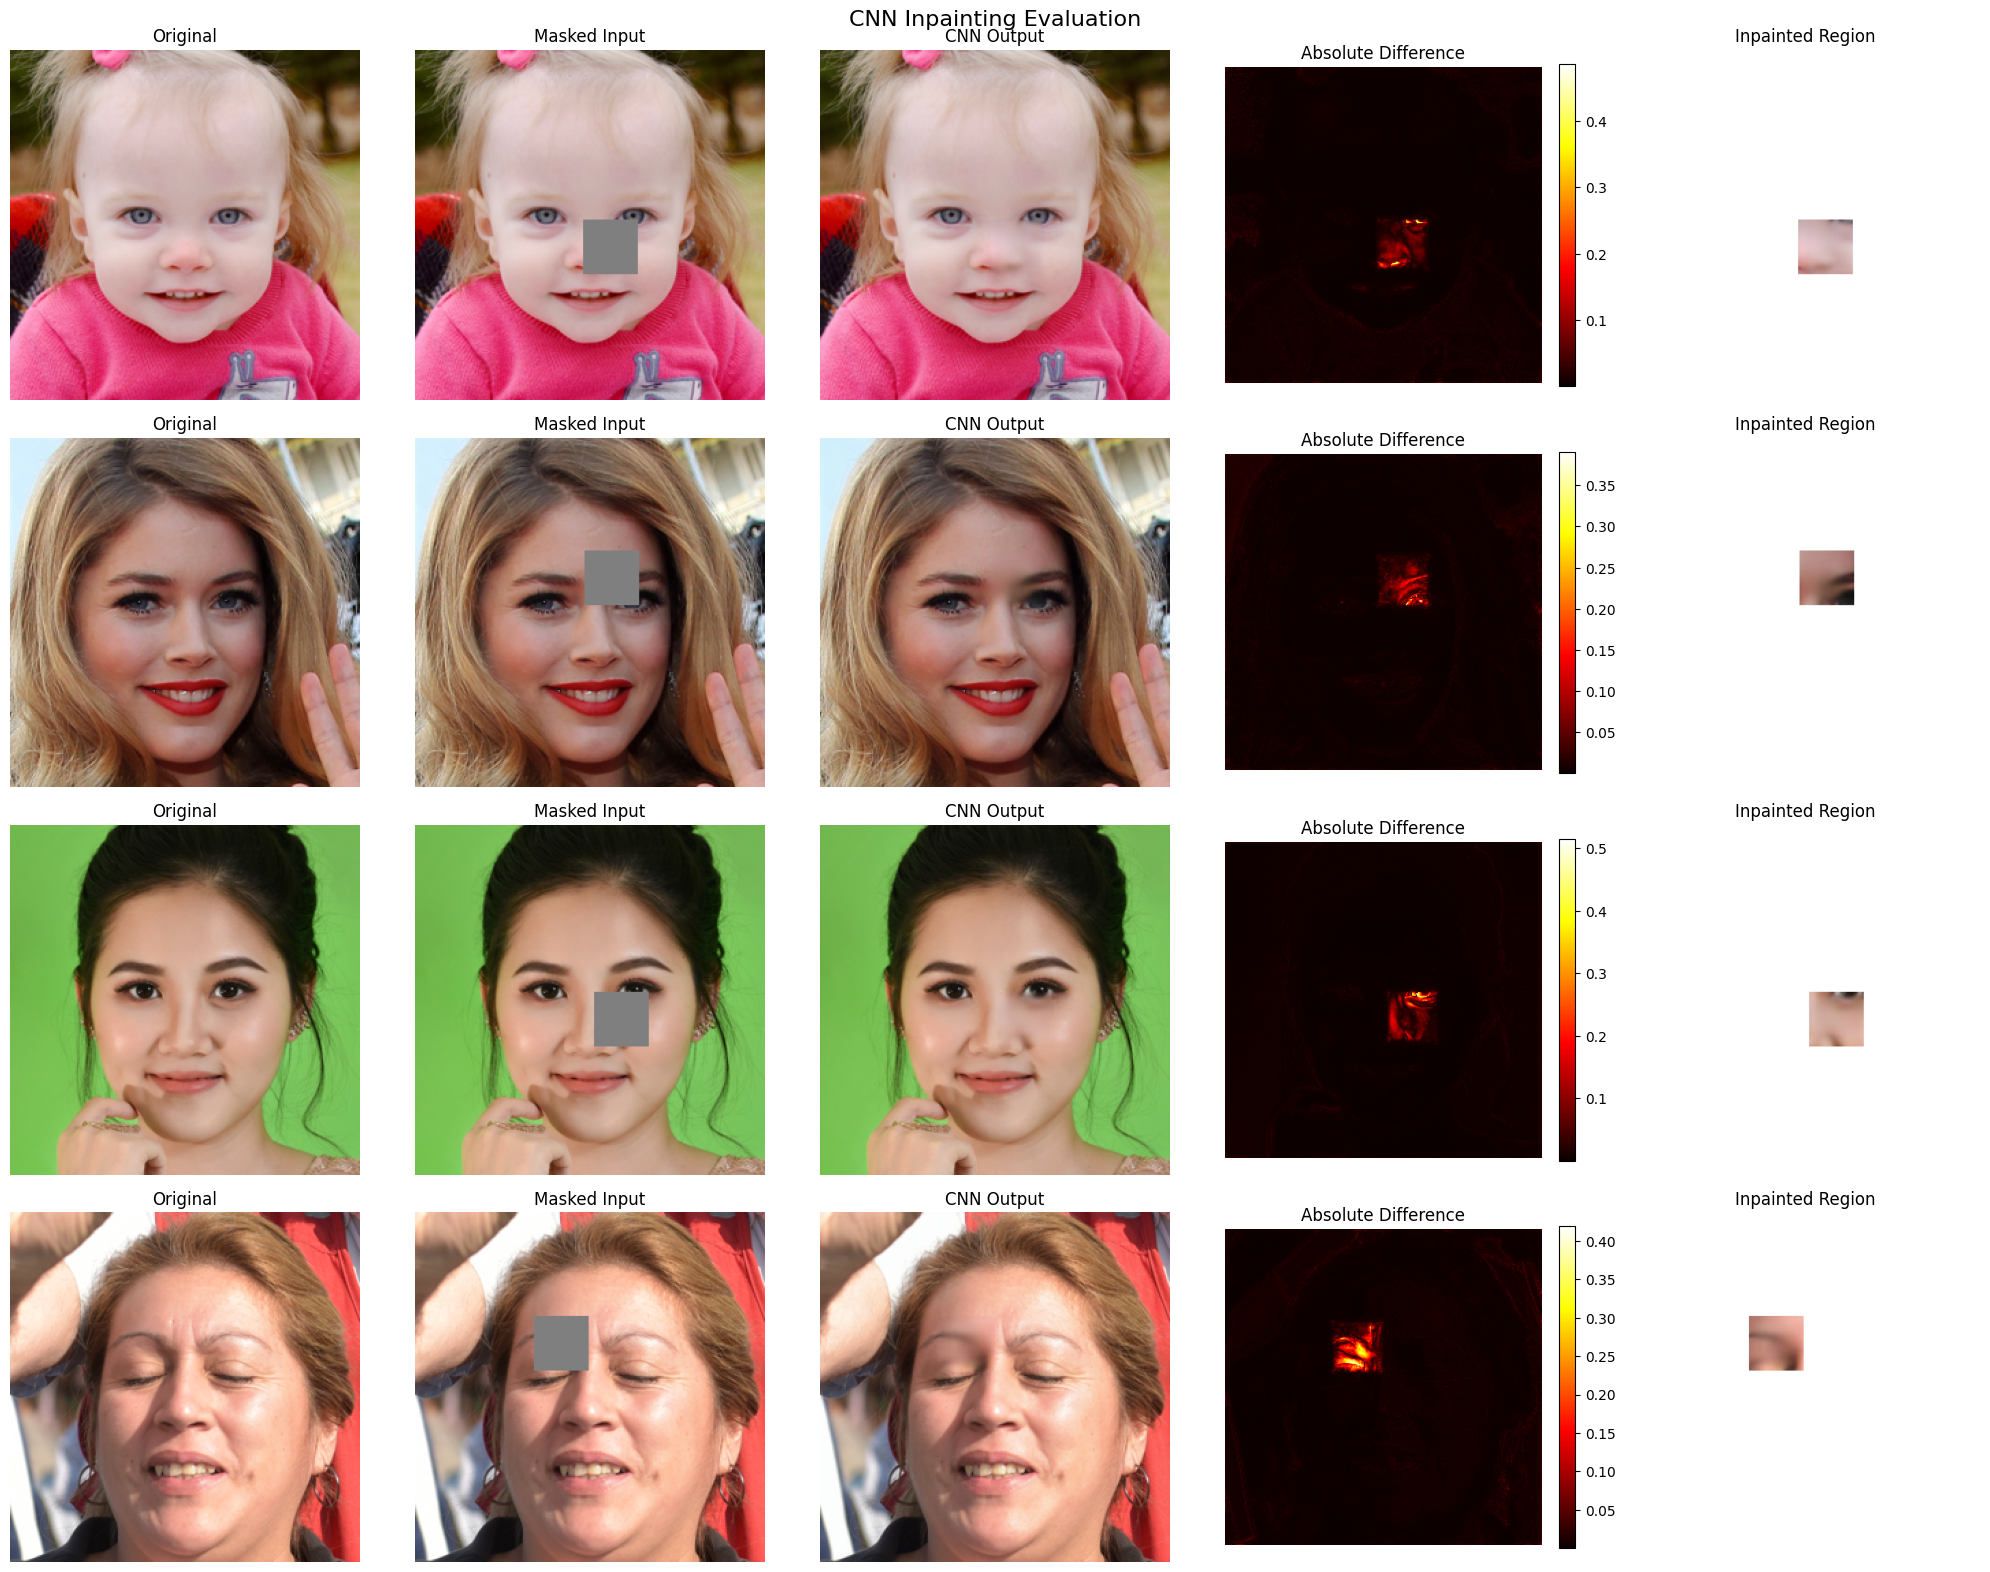


✅ Evaluation complete! Results saved to 'cnn_evaluation_results.txt'


In [ ]:
# --- CNN Evaluation with Comprehensive Metrics ---
print("--- Evaluating CNN Model ---")

# Initialize the correct model
cnn_model = UNetSR(in_channels=4, out_channels=3)

# Load weights
state_dict = torch.load('/content/drive/MyDrive/ColabNotebooks/Vision/diffusionProject/final_cnn_model.pth', map_location=DEVICE)
if any(k.startswith('_orig_mod.') for k in state_dict.keys()):
    state_dict = {k.replace('_orig_mod.', ''): v for k, v in state_dict.items()}
cnn_model.load_state_dict(state_dict)

cnn_model.to(DEVICE)
cnn_model.eval()

# --- Initialize All Metrics ---
# 1. Basic metrics
psnr_metric = torchmetrics.PeakSignalNoiseRatio(data_range=1.0).to(DEVICE)
ssim_metric = torchmetrics.StructuralSimilarityIndexMeasure(data_range=1.0).to(DEVICE)

# 2. Perceptual metric (used in ResDiff paper)
lpips_metric = lpips.LPIPS(net='alex').to(DEVICE)  # Lower is better

# 3. Feature-based metric
fid_metric = FrechetInceptionDistance(feature=2048).to(DEVICE)

# Get evaluation batch
eval_dataloader = val_dataloader

# Collect metrics across multiple batches
all_psnr = []
all_ssim = []
all_lpips = []
all_mse = []
all_mae = []
all_masked_mse = []
all_masked_mae = []

print("Evaluating on multiple batches...")
for batch_idx, batch in enumerate(eval_dataloader):
    if batch_idx >= 10:  # Evaluate on 10 batches
        break

    original_images = batch.to(DEVICE)

    with torch.no_grad():
        masked_images, masks = create_mask(original_images)
        masks = masks.to(DEVICE)

        cnn_input = torch.cat((masked_images, masks[:, 0:1, :, :]), dim=1)
        cnn_reconstructions = cnn_model(cnn_input)

    # Denormalize from [-1, 1] to [0, 1]
    original_denorm = (original_images + 1) / 2
    recon_denorm = (cnn_reconstructions + 1) / 2

    # 1. PSNR and SSIM
    batch_psnr = psnr_metric(recon_denorm, original_denorm)
    batch_ssim = ssim_metric(recon_denorm, original_denorm)
    all_psnr.append(batch_psnr.item())
    all_ssim.append(batch_ssim.item())

    # 2. LPIPS (Perceptual loss)
    batch_lpips = lpips_metric(original_denorm * 2 - 1, recon_denorm * 2 - 1)  # LPIPS expects [-1, 1]
    all_lpips.append(batch_lpips.mean().item())

    # 3. MSE and MAE
    mse = torch.nn.functional.mse_loss(recon_denorm, original_denorm)
    mae = torch.nn.functional.l1_loss(recon_denorm, original_denorm)
    all_mse.append(mse.item())
    all_mae.append(mae.item())

    # 4. Masked region metrics
    mask_binary = (masks[:, 0:1, :, :] == 0).float()
    if mask_binary.sum() > 0:
        masked_mse = ((recon_denorm - original_denorm) ** 2 * mask_binary).sum() / mask_binary.sum()
        masked_mae = (torch.abs(recon_denorm - original_denorm) * mask_binary).sum() / mask_binary.sum()
        all_masked_mse.append(masked_mse.item())
        all_masked_mae.append(masked_mae.item())

    # Update FID metric
    # Convert to uint8 format expected by FID
    real_images_uint8 = (original_denorm * 255).to(torch.uint8)
    fake_images_uint8 = (recon_denorm * 255).to(torch.uint8)
    fid_metric.update(real_images_uint8, real=True)
    fid_metric.update(fake_images_uint8, real=False)

# Calculate FID
fid_score = fid_metric.compute()

# --- Print Comprehensive Results ---
print("\n" + "="*50)
print("CNN INPAINTING EVALUATION RESULTS")
print("="*50)

print("\n📊 RECONSTRUCTION METRICS:")
print(f"  PSNR:  {np.mean(all_psnr):.2f} ± {np.std(all_psnr):.2f} dB")
print(f"  SSIM:  {np.mean(all_ssim):.4f} ± {np.std(all_ssim):.4f}")
print(f"  MSE:   {np.mean(all_mse):.4f} ± {np.std(all_mse):.4f}")
print(f"  MAE:   {np.mean(all_mae):.4f} ± {np.std(all_mae):.4f}")

print("\n🎨 PERCEPTUAL METRICS:")
print(f"  LPIPS: {np.mean(all_lpips):.4f} ± {np.std(all_lpips):.4f} (lower is better)")
print(f"  FID:   {fid_score:.2f} (lower is better)")

print("\n🎯 MASKED REGION METRICS:")
print(f"  Masked MSE: {np.mean(all_masked_mse):.4f} ± {np.std(all_masked_mse):.4f}")
print(f"  Masked MAE: {np.mean(all_masked_mae):.4f} ± {np.std(all_masked_mae):.4f}")

# --- Frequency Domain Analysis ---
print("\n📈 FREQUENCY DOMAIN ANALYSIS:")
with torch.no_grad():
    # Get one batch for frequency analysis
    test_batch = next(iter(eval_dataloader)).to(DEVICE)
    masked_test, masks_test = create_mask(test_batch)
    masks_test = masks_test.to(DEVICE)

    cnn_input_test = torch.cat((masked_test, masks_test[:, 0:1, :, :]), dim=1)
    recon_test = cnn_model(cnn_input_test)

    # FFT Analysis
    fft_original = torch.fft.fft2(test_batch, dim=(-2, -1))
    fft_recon = torch.fft.fft2(recon_test, dim=(-2, -1))

    # Compare frequency magnitudes
    mag_original = torch.abs(fft_original).mean()
    mag_recon = torch.abs(fft_recon).mean()

    # High frequency analysis (outer regions of FFT)
    h, w = test_batch.shape[-2:]
    mask_high_freq = torch.ones_like(test_batch)
    mask_high_freq[:, :, h//4:3*h//4, w//4:3*w//4] = 0

    high_freq_original = (torch.abs(fft_original) * mask_high_freq).mean()
    high_freq_recon = (torch.abs(fft_recon) * mask_high_freq).mean()

    print(f"  Average Frequency Magnitude Ratio: {(mag_recon/mag_original):.3f}")
    print(f"  High-Frequency Recovery Ratio: {(high_freq_recon/high_freq_original):.3f}")

# --- Visualization with Difference Maps ---
num_to_show = 4
fig, axes = plt.subplots(num_to_show, 5, figsize=(20, num_to_show * 4))
fig.suptitle('CNN Inpainting Evaluation', fontsize=16)

# Get samples for visualization
vis_batch = next(iter(eval_dataloader)).to(DEVICE)
with torch.no_grad():
    vis_masked, vis_masks = create_mask(vis_batch[:num_to_show])
    vis_masks = vis_masks.to(DEVICE)
    vis_input = torch.cat((vis_masked, vis_masks[:, 0:1, :, :]), dim=1)
    vis_recon = cnn_model(vis_input)

for i in range(num_to_show):
    # Original
    axes[i, 0].imshow(tensor_to_image(vis_batch[i]))
    axes[i, 0].set_title("Original")
    axes[i, 0].axis('off')

    # Masked Input
    axes[i, 1].imshow(tensor_to_image(vis_masked[i]))
    axes[i, 1].set_title("Masked Input")
    axes[i, 1].axis('off')

    # CNN Reconstruction
    axes[i, 2].imshow(tensor_to_image(vis_recon[i]))
    axes[i, 2].set_title(f"CNN Output")
    axes[i, 2].axis('off')

    # Difference Map
    diff = torch.abs(vis_batch[i] - vis_recon[i]).mean(dim=0)
    im = axes[i, 3].imshow(diff.cpu().numpy(), cmap='hot')
    axes[i, 3].set_title("Absolute Difference")
    axes[i, 3].axis('off')
    plt.colorbar(im, ax=axes[i, 3], fraction=0.046)

    # Masked Region Only
    mask_vis = vis_masks[i, 0].cpu().numpy()
    masked_recon = tensor_to_image(vis_recon[i])
    masked_recon[mask_vis > 0.5] = 1  # Highlight unmasked regions
    axes[i, 4].imshow(masked_recon)
    axes[i, 4].set_title("Inpainted Region")
    axes[i, 4].axis('off')

plt.tight_layout()
plt.show()

# --- Save Results Summary ---
results_summary = f"""
CNN Inpainting Evaluation Results
=================================
PSNR: {np.mean(all_psnr):.2f} ± {np.std(all_psnr):.2f} dB
SSIM: {np.mean(all_ssim):.4f} ± {np.std(all_ssim):.4f}
LPIPS: {np.mean(all_lpips):.4f} ± {np.std(all_lpips):.4f}
FID: {fid_score:.2f}
Masked MSE: {np.mean(all_masked_mse):.4f}
Masked MAE: {np.mean(all_masked_mae):.4f}
"""

with open('cnn_evaluation_results.txt', 'w') as f:
    f.write(results_summary)

print("\n✅ Evaluation complete! Results saved to 'cnn_evaluation_results.txt'")

# GAN
Adding the finegrained details.

In [ ]:
# ============================================
# 1. GENERATOR - Residual Refinement Network
# ============================================

class ResidualBlock(nn.Module):
    """Residual block with spectral normalization"""
    def __init__(self, channels):
        super().__init__()
        self.conv1 = spectral_norm(nn.Conv2d(channels, channels, 3, 1, 1))
        self.conv2 = spectral_norm(nn.Conv2d(channels, channels, 3, 1, 1))
        self.norm1 = nn.InstanceNorm2d(channels)
        self.norm2 = nn.InstanceNorm2d(channels)

    def forward(self, x):
        residual = x
        x = F.leaky_relu(self.norm1(self.conv1(x)), 0.2)
        x = self.norm2(self.conv2(x))
        return x + residual

class SelfAttention(nn.Module):
    """Self-attention layer for capturing long-range dependencies"""
    def __init__(self, channels):
        super().__init__()
        self.query = spectral_norm(nn.Conv2d(channels, channels // 8, 1))
        self.key = spectral_norm(nn.Conv2d(channels, channels // 8, 1))
        self.value = spectral_norm(nn.Conv2d(channels, channels, 1))
        self.gamma = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        b, c, h, w = x.shape

        q = self.query(x).view(b, -1, h * w).permute(0, 2, 1)
        k = self.key(x).view(b, -1, h * w)
        v = self.value(x).view(b, -1, h * w)

        attention = F.softmax(torch.bmm(q, k), dim=-1)
        out = torch.bmm(v, attention.permute(0, 2, 1))
        out = out.view(b, c, h, w)

        return self.gamma * out + x

class RefinementGenerator(nn.Module):
    """Generator that refines CNN output"""
    def __init__(self, in_channels=7, out_channels=3, base_channels=64):
        super().__init__()

        # Input: CNN output (3) + original masked (3) + mask (1) = 7 channels
        self.encoder = nn.Sequential(
            spectral_norm(nn.Conv2d(in_channels, base_channels, 7, 1, 3)),
            nn.LeakyReLU(0.2, True)
        )

        # Downsampling
        self.down1 = nn.Sequential(
            spectral_norm(nn.Conv2d(base_channels, base_channels * 2, 4, 2, 1)),
            nn.InstanceNorm2d(base_channels * 2),
            nn.LeakyReLU(0.2, True)
        )

        self.down2 = nn.Sequential(
            spectral_norm(nn.Conv2d(base_channels * 2, base_channels * 4, 4, 2, 1)),
            nn.InstanceNorm2d(base_channels * 4),
            nn.LeakyReLU(0.2, True)
        )

        # Residual blocks with attention
        self.res_blocks = nn.Sequential(
            ResidualBlock(base_channels * 4),
            ResidualBlock(base_channels * 4),
            SelfAttention(base_channels * 4),
            ResidualBlock(base_channels * 4),
            ResidualBlock(base_channels * 4),
        )

        # Upsampling
        self.up1 = nn.Sequential(
            spectral_norm(nn.ConvTranspose2d(base_channels * 4, base_channels * 2, 4, 2, 1)),
            nn.InstanceNorm2d(base_channels * 2),
            nn.LeakyReLU(0.2, True)
        )

        self.up2 = nn.Sequential(
            spectral_norm(nn.ConvTranspose2d(base_channels * 2, base_channels, 4, 2, 1)),
            nn.InstanceNorm2d(base_channels),
            nn.LeakyReLU(0.2, True)
        )

        # Output residual
        self.output = nn.Sequential(
            spectral_norm(nn.Conv2d(base_channels, out_channels, 7, 1, 3)),
            nn.Tanh()
        )

        # Learnable residual weight
        self.residual_weight = nn.Parameter(torch.tensor(0.1))

    def forward(self, cnn_output, masked_image, mask):
        """
        Args:
            cnn_output: CNN's coarse prediction [B, 3, H, W]
            masked_image: Original image with mask applied [B, 3, H, W]
            mask: Binary mask [B, 1, H, W]
        """
        # Concatenate inputs
        x = torch.cat([cnn_output, masked_image, mask], dim=1)

        # Encode
        x = self.encoder(x)

        # Downsample
        d1 = self.down1(x)
        d2 = self.down2(d1)

        # Process with residual blocks
        x = self.res_blocks(d2)

        # Upsample with skip connections
        x = self.up1(x)
        x = self.up2(x + d1)  # Skip connection

        # Generate residual
        residual = self.output(x)

        # Add weighted residual to CNN output
        refined = cnn_output + self.residual_weight * residual

        # Ensure output is in [-1, 1]
        return torch.tanh(refined)

In [ ]:
# ============================================
# 2. DISCRIMINATOR - Multi-scale PatchGAN
# ============================================

class MultiscaleDiscriminator(nn.Module):
    """Multi-scale discriminator for better gradient flow"""
    def __init__(self, in_channels=3, base_channels=64, num_scales=3):
        super().__init__()

        self.num_scales = num_scales
        self.discriminators = nn.ModuleList()

        for _ in range(num_scales):
            self.discriminators.append(self._make_discriminator(in_channels, base_channels))

        self.downsample = nn.AvgPool2d(2)

    def _make_discriminator(self, in_channels, base_channels):
        return nn.Sequential(
            spectral_norm(nn.Conv2d(in_channels, base_channels, 4, 2, 1)),
            nn.LeakyReLU(0.2, True),

            spectral_norm(nn.Conv2d(base_channels, base_channels * 2, 4, 2, 1)),
            nn.InstanceNorm2d(base_channels * 2),
            nn.LeakyReLU(0.2, True),

            spectral_norm(nn.Conv2d(base_channels * 2, base_channels * 4, 4, 2, 1)),
            nn.InstanceNorm2d(base_channels * 4),
            nn.LeakyReLU(0.2, True),

            spectral_norm(nn.Conv2d(base_channels * 4, base_channels * 8, 4, 1, 1)),
            nn.InstanceNorm2d(base_channels * 8),
            nn.LeakyReLU(0.2, True),

            spectral_norm(nn.Conv2d(base_channels * 8, 1, 4, 1, 1))
        )

    def forward(self, x):
        outputs = []

        for i in range(self.num_scales):
            outputs.append(self.discriminators[i](x))
            if i < self.num_scales - 1:
                x = self.downsample(x)

        return outputs

In [ ]:
# ============================================
# 3. LOSS FUNCTIONS
# ============================================

class PerceptualLoss(nn.Module):
    """VGG-based perceptual loss"""
    def __init__(self):
        super().__init__()
        import torchvision.models as models
        vgg = models.vgg19(pretrained=True).features

        # Extract specific layers
        self.layers = nn.ModuleList([
            vgg[:4],   # relu1_2
            vgg[4:9],  # relu2_2
            vgg[9:18], # relu3_4
        ])

        # Freeze VGG
        for param in self.parameters():
            param.requires_grad = False

        # Normalization
        self.register_buffer('mean', torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1))
        self.register_buffer('std', torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1))

    def forward(self, pred, target):
        # Normalize from [-1, 1] to [0, 1]
        pred = (pred + 1) / 2
        target = (target + 1) / 2

        # VGG normalization
        pred = (pred - self.mean) / self.std
        target = (target - self.mean) / self.std

        loss = 0
        x_pred, x_target = pred, target

        for layer in self.layers:
            x_pred = layer(x_pred)
            x_target = layer(x_target)
            loss += F.l1_loss(x_pred, x_target)

        return loss

def hinge_loss_d(real_pred, fake_pred):
    """Hinge loss for discriminator"""
    loss = 0
    for real_p, fake_p in zip(real_pred, fake_pred):
        loss += torch.mean(F.relu(1 - real_p)) + torch.mean(F.relu(1 + fake_p))
    return loss / len(real_pred)

def hinge_loss_g(fake_pred):
    """Hinge loss for generator"""
    loss = 0
    for fake_p in fake_pred:
        loss += -torch.mean(fake_p)
    return loss / len(fake_pred)

In [ ]:
# ============================================
# 4. TRAINING FUNCTION
# ============================================

def train_gan(generator, discriminator, cnn_model, train_loader, val_loader,
              num_epochs=100, device='cuda'):
    """Train the GAN for refinement"""

    # Optimizers
    g_optimizer = optim.Adam(generator.parameters(), lr=1e-4, betas=(0.0, 0.999))
    d_optimizer = optim.Adam(discriminator.parameters(), lr=4e-4, betas=(0.0, 0.999))

    # Loss functions
    l1_loss = nn.L1Loss()
    perceptual_loss = PerceptualLoss().to(device)

    # Training history
    history = {'g_loss': [], 'd_loss': [], 'val_psnr': []}

    # Training loop
    for epoch in range(num_epochs):
        generator.train()
        discriminator.train()

        epoch_g_loss = 0
        epoch_d_loss = 0

        pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}')
        for batch_idx, batch in enumerate(pbar):
            real_images = batch.to(device)
            batch_size = real_images.size(0)

            # Create masks and get CNN predictions
            with torch.no_grad():
                masked_images, masks = create_mask(real_images, mask_percentage=0.025)
                masks = masks.to(device)

                cnn_input = torch.cat([masked_images, masks[:, 0:1]], dim=1)
                coarse_output = cnn_model(cnn_input)

            # ==================
            # Train Discriminator
            # ==================
            d_optimizer.zero_grad()

            # Generate refined images
            refined_images = generator(coarse_output, masked_images, masks[:, 0:1])

            # Discriminator predictions
            real_pred = discriminator(real_images)
            fake_pred = discriminator(refined_images.detach())

            # Hinge loss
            d_loss = hinge_loss_d(real_pred, fake_pred)

            d_loss.backward()
            d_optimizer.step()

            # ==================
            # Train Generator
            # ==================
            # Train generator every 1 discriminator steps
            if batch_idx % 1 == 0:
                g_optimizer.zero_grad()

                # Generate refined images
                refined_images = generator(coarse_output, masked_images, masks[:, 0:1])

                # Adversarial loss
                fake_pred = discriminator(refined_images)
                g_adv_loss = hinge_loss_g(fake_pred)

                # L1 loss (reconstruction)
                g_l1_loss = l1_loss(refined_images, real_images) * 10

                # Perceptual loss
                g_perc_loss = perceptual_loss(refined_images, real_images) * 0.1

                # Mask-weighted loss (focus on inpainted regions)
                hole_mask = 1 - masks
                g_hole_loss = l1_loss(refined_images * hole_mask, real_images * hole_mask) * 20

                # Total generator loss
                g_loss = g_adv_loss + g_l1_loss + g_perc_loss + g_hole_loss

                g_loss.backward()
                g_optimizer.step()

                # Update residual weight (optional)
                generator.residual_weight.data.clamp_(0.05, 0.5)

            # Update progress bar
            epoch_g_loss += g_loss.item()
            epoch_d_loss += d_loss.item()
            pbar.set_postfix({
                'G': f'{g_loss.item():.4f}',
                'D': f'{d_loss.item():.4f}',
                'α': f'{generator.residual_weight.item():.3f}'
            })

        # Validation
        if epoch % 5 == 0:
            val_psnr = validate_gan(generator, cnn_model, val_loader, device)
            history['val_psnr'].append(val_psnr)
            print(f"\nValidation PSNR: {val_psnr:.2f} dB")

            # Save sample images
            save_samples(generator, cnn_model, val_loader, epoch, device)

        # Save checkpoint
        if epoch % 10 == 0:
            torch.save({
                'generator': generator.state_dict(),
                'discriminator': discriminator.state_dict(),
                'g_optimizer': g_optimizer.state_dict(),
                'd_optimizer': d_optimizer.state_dict(),
                'epoch': epoch
            }, f'gan_checkpoint_epoch_{epoch}.pth')

        history['g_loss'].append(epoch_g_loss / len(train_loader))
        history['d_loss'].append(epoch_d_loss / len(train_loader))

    return history

# ============================================
# 5. VALIDATION AND INFERENCE
# ============================================

def validate_gan(generator, cnn_model, val_loader, device):
    """Calculate validation metrics"""
    generator.eval()
    total_psnr = 0
    count = 0

    with torch.no_grad():
        for batch in val_loader:
            real_images = batch.to(device)

            # Create masks and get CNN predictions
            masked_images, masks = create_mask(real_images, mask_percentage=0.025)
            masks = masks.to(device)

            cnn_input = torch.cat([masked_images, masks[:, 0:1]], dim=1)
            coarse_output = cnn_model(cnn_input)

            # Generate refined images
            refined_images = generator(coarse_output, masked_images, masks[:, 0:1])

            # Calculate PSNR
            mse = F.mse_loss((refined_images + 1) / 2, (real_images + 1) / 2)
            psnr = 20 * torch.log10(torch.tensor(1.0)) - 10 * torch.log10(mse)

            total_psnr += psnr.item() * real_images.size(0)
            count += real_images.size(0)

    return total_psnr / count

def save_samples(generator, cnn_model, val_loader, epoch, device):
    """Save sample images"""
    generator.eval()

    with torch.no_grad():
        batch = next(iter(val_loader))
        real_images = batch[:4].to(device)

        # Create masks and get CNN predictions
        masked_images, masks = create_mask(real_images, mask_percentage=0.025)
        masks = masks.to(device)

        cnn_input = torch.cat([masked_images, masks[:, 0:1]], dim=1)
        coarse_output = cnn_model(cnn_input)

        # Generate refined images
        refined_images = generator(coarse_output, masked_images, masks[:, 0:1])

        # Create comparison grid
        comparison = torch.cat([
            (real_images + 1) / 2,
            (masked_images + 1) / 2,
            (coarse_output + 1) / 2,
            (refined_images + 1) / 2
        ], dim=0)

        save_image(comparison, f'gan_samples_epoch_{epoch}.png', nrow=4)

# ============================================
# 6. USAGE EXAMPLE
# ============================================

def main():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Initialize models
    generator = RefinementGenerator(in_channels=7, out_channels=3).to(device)
    discriminator = MultiscaleDiscriminator(in_channels=3).to(device)

    # Load your pre-trained CNN
    cnn_model = UNetSR().to(device)  # Use the same initialization as training!

    # Load and fix the state dict
    cnn_state_dict = torch.load('final_cnn_model.pth', map_location=device)

    # Remove _orig_mod. prefix if it exists
    if any(k.startswith('_orig_mod.') for k in cnn_state_dict.keys()):
        cnn_state_dict = {k.replace('_orig_mod.', ''): v for k, v in cnn_state_dict.items()}

    # Now load the fixed state dict
    cnn_model.load_state_dict(cnn_state_dict)

    # Set to eval and freeze
    cnn_model.eval()
    for param in cnn_model.parameters():
        param.requires_grad = False

    print("✅ CNN loaded successfully")

    # Train
    history = train_gan(
        generator,
        discriminator,
        cnn_model,
        train_loader=diffusion_dataloader,
        val_loader=val_dataloader,
        num_epochs=50,
        device=device
    )

    # Save final models
    torch.save(generator.state_dict(), 'gan_generator_final.pth')
    torch.save(discriminator.state_dict(), 'gan_discriminator_final.pth')

# ============================================
# 7. INFERENCE FUNCTION
# ============================================

def inference_gan(generator, cnn_model, image, mask, device):
    """Run inference with the trained GAN"""
    generator.eval()
    cnn_model.eval()

    with torch.no_grad():
        # Get CNN prediction
        masked_image = image * mask
        cnn_input = torch.cat([masked_image, mask[:, 0:1]], dim=1)
        coarse_output = cnn_model(cnn_input)

        # Refine with GAN
        refined = generator(coarse_output, masked_image, mask[:, 0:1])

        # Ensure unmasked regions are preserved
        final_output = refined * (1 - mask) + image * mask

        return final_output, coarse_output

if __name__ == "__main__":
    main()

✅ CNN loaded successfully


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:04<00:00, 122MB/s]
Epoch 1/50: 100%|██████████| 250/250 [00:28<00:00,  8.66it/s, G=0.9877, D=1.9960, α=0.119]



Validation PSNR: 29.19 dB


Epoch 6/50: 100%|██████████| 250/250 [00:28<00:00,  8.78it/s, G=0.6856, D=1.9950, α=0.280]



Validation PSNR: 30.28 dB


Epoch 11/50: 100%|██████████| 250/250 [00:28<00:00,  8.83it/s, G=0.9517, D=1.5595, α=0.406]



Validation PSNR: 32.37 dB


Epoch 16/50: 100%|██████████| 250/250 [00:27<00:00,  8.96it/s, G=1.1640, D=1.0684, α=0.500]



Validation PSNR: 32.86 dB


Epoch 21/50: 100%|██████████| 250/250 [00:28<00:00,  8.75it/s, G=1.5863, D=1.0531, α=0.500]



Validation PSNR: 33.28 dB


Epoch 26/50: 100%|██████████| 250/250 [00:28<00:00,  8.90it/s, G=1.4065, D=1.0876, α=0.500]



Validation PSNR: 32.90 dB


Epoch 31/50: 100%|██████████| 250/250 [00:27<00:00,  8.98it/s, G=1.6984, D=0.5637, α=0.500]



Validation PSNR: 33.62 dB


Epoch 36/50: 100%|██████████| 250/250 [00:27<00:00,  8.93it/s, G=1.3262, D=0.4467, α=0.500]



Validation PSNR: 33.02 dB


Epoch 41/50: 100%|██████████| 250/250 [00:28<00:00,  8.91it/s, G=1.8030, D=0.7390, α=0.500]



Validation PSNR: 33.46 dB


Epoch 46/50: 100%|██████████| 250/250 [00:28<00:00,  8.93it/s, G=1.8470, D=0.2555, α=0.500]



Validation PSNR: 33.28 dB


Epoch 50/50: 100%|██████████| 250/250 [00:27<00:00,  9.03it/s, G=0.8009, D=1.1690, α=0.500]


Initializing models...
Loading weights...
✅ All weights loaded successfully.
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.11/dist-packages/lpips/weights/v0.1/alex.pth

📊 Evaluating on the test set...


Evaluating:   0%|          | 0/250 [00:00<?, ?it/s]


INPAINTING EVALUATION RESULTS (CNN vs GAN)

🔷 CNN MODEL (COARSE):
  PSNR:  38.93 ± 1.50 dB
  SSIM:  0.9892 ± 0.0044
  MAE:   0.0035 ± 0.0002
  LPIPS: 0.0090 ± 0.0021
  Time:  0.005 ± 0.002 sec

🔶 GAN MODEL (REFINED):
  PSNR:  39.27 ± 1.70 dB
  SSIM:  0.9928 ± 0.0008
  MAE:   0.0012 ± 0.0002
  LPIPS: 0.0077 ± 0.0018
  Time:  0.007 ± 0.002 sec

📈 IMPROVEMENT (GAN vs CNN):
  PSNR:  +0.34 dB
  SSIM:  +0.0037
  MAE:   -0.0024
  LPIPS: -0.0013

🎨 Generating improved visualizations...

🎨 Generating visualization with random samples...


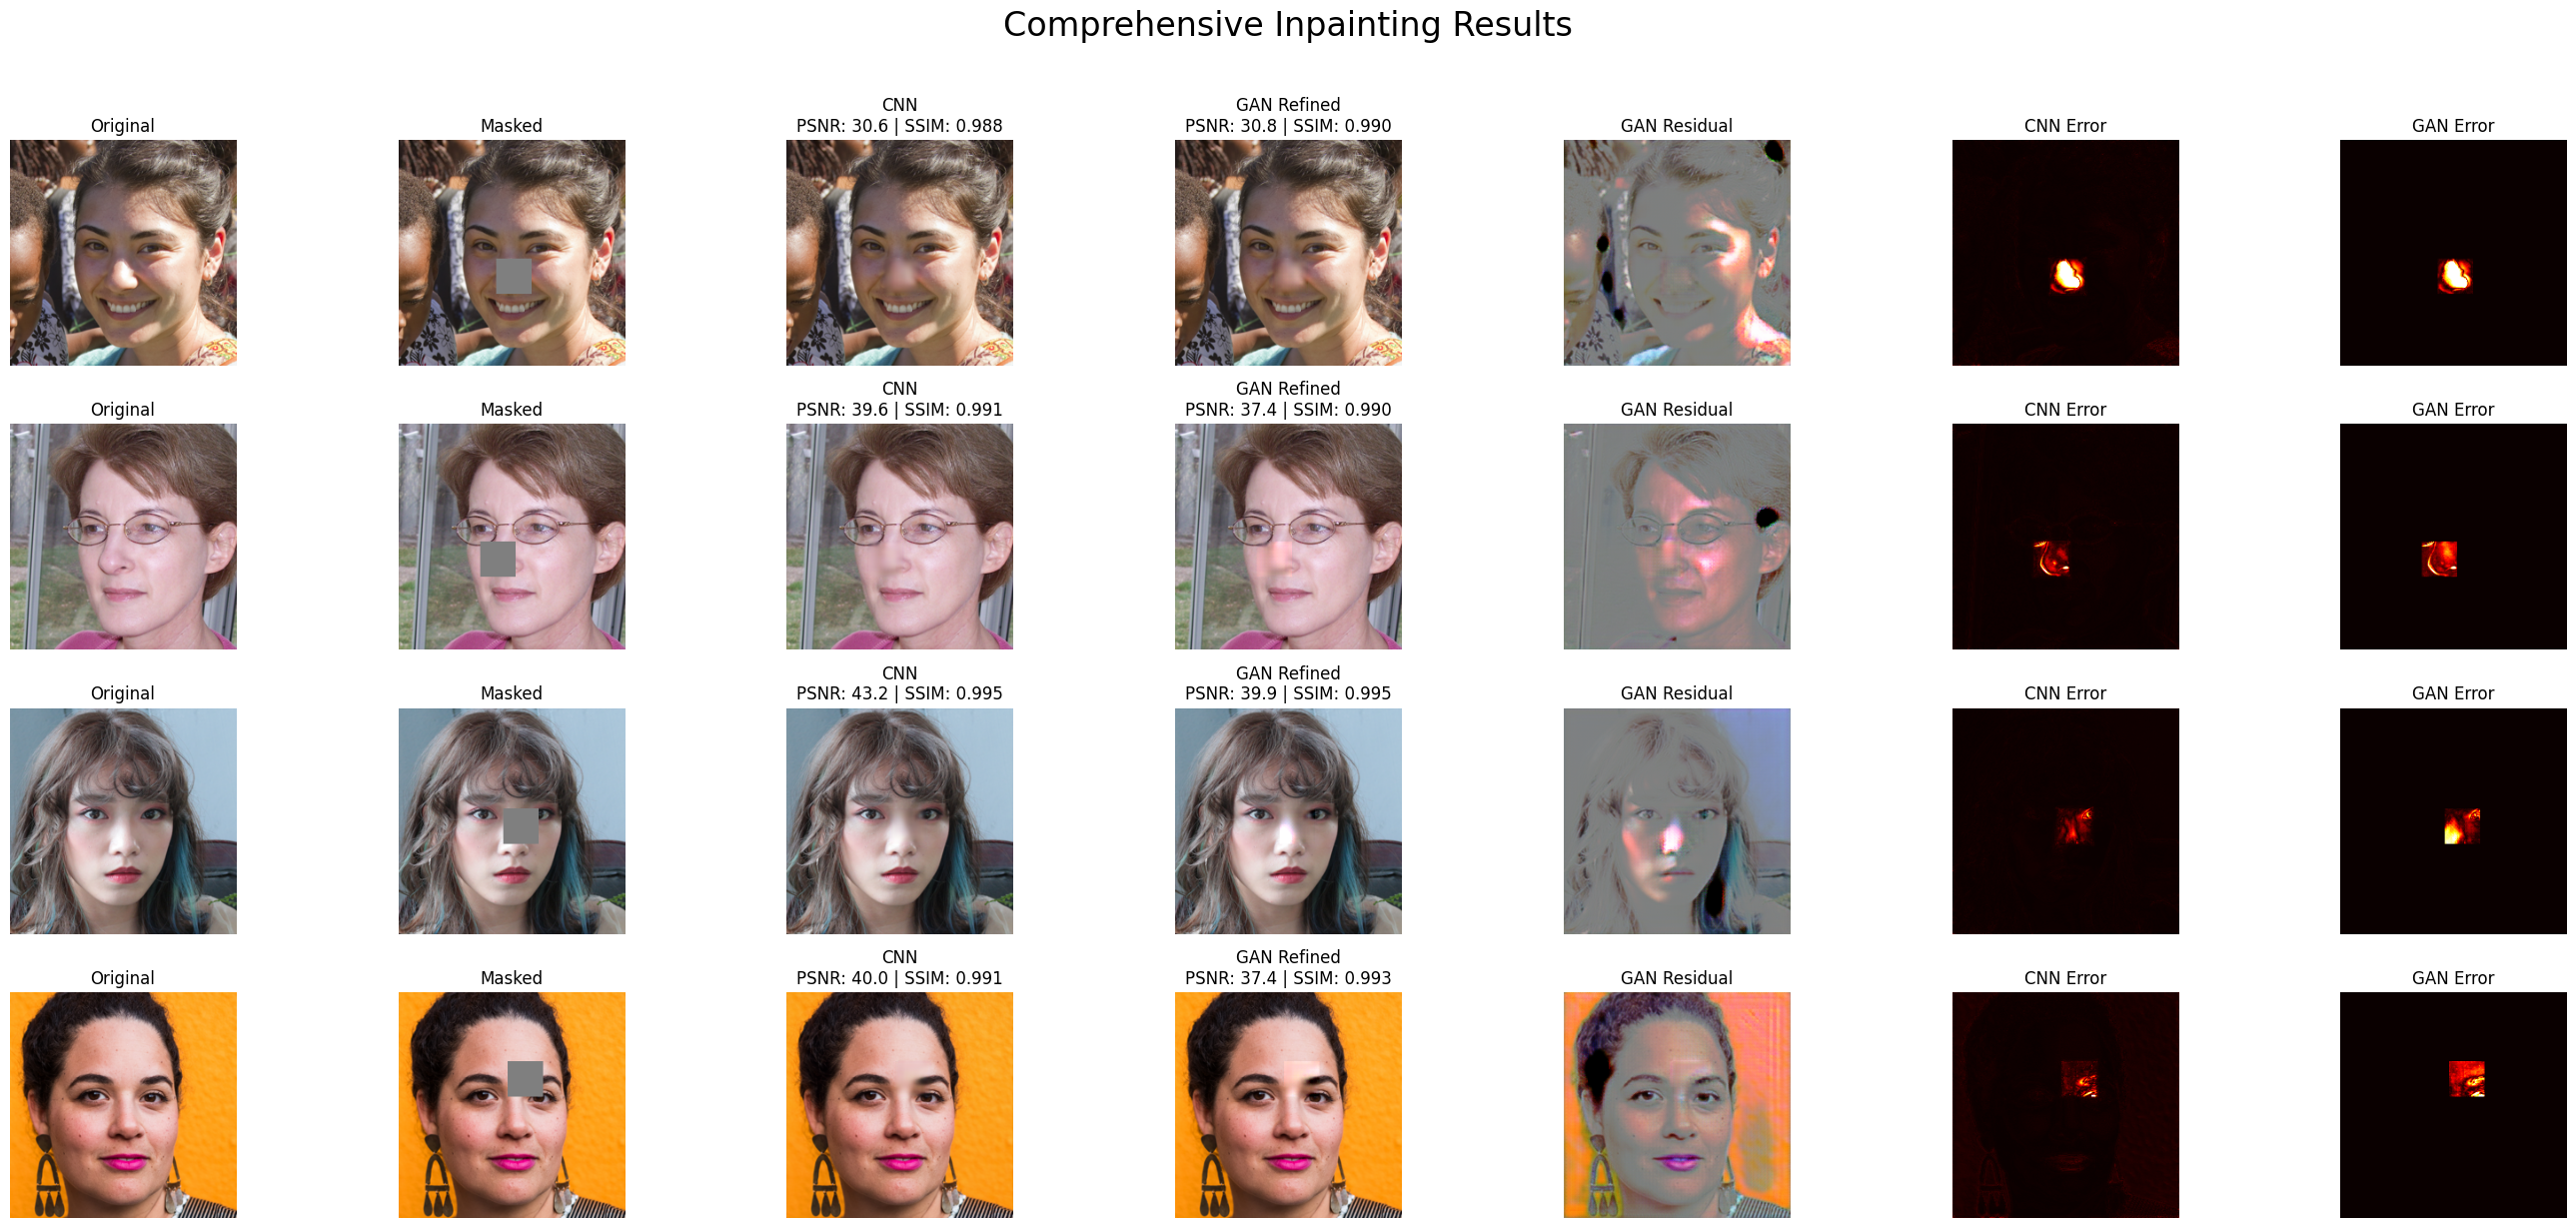


✅ All visualizations saved.

💾 Saving results summary to text file...

✅ Evaluation complete! All results saved to 'gan_evaluation_results.txt'


In [ ]:
import torch
import torch.nn.functional as F
import torchmetrics
import lpips
import numpy as np
import time
import matplotlib.pyplot as plt
from torchvision.utils import save_image, make_grid
from tqdm.autonotebook import tqdm

def tensor_to_image(tensor):
    """
    Converts a PyTorch tensor to a NumPy image array for visualization.
    It handles denormalization and permutes the dimensions correctly.
    """
    # Denormalize from [-1, 1] to [0, 1]
    image = (tensor.clamp(-1, 1) + 1) / 2
    # Move from (C, H, W) to (H, W, C) for Matplotlib
    return image.permute(1, 2, 0)

# Assume lpips is available
lpips_available = True

# ============================================
# 1. INITIALIZE AND LOAD MODELS
# ============================================
print("Initializing models...")
# Initialize your CNN
cnn_model = UNetSR(in_channels=4, out_channels=3).to(DEVICE)
# Initialize your GAN Generator
generator = RefinementGenerator(in_channels=7, out_channels=3).to(DEVICE)

# --- LOAD WEIGHTS ---
CNN_WEIGHTS_PATH = 'final_cnn_model.pth' # Use your best CNN model
GENERATOR_WEIGHTS_PATH = 'gan_generator_final.pth' # Use your final GAN generator weights

print(f"Loading weights...")
# Load CNN
cnn_state_dict = torch.load(CNN_WEIGHTS_PATH, map_location=DEVICE)
if any(k.startswith('_orig_mod.') for k in cnn_state_dict.keys()):
    cnn_state_dict = {k.replace('_orig_mod.', ''): v for k, v in cnn_state_dict.items()}
cnn_model.load_state_dict(cnn_state_dict)

# Load GAN Generator
generator_state_dict = torch.load(GENERATOR_WEIGHTS_PATH, map_location=DEVICE)
if any(k.startswith('_orig_mod.') for k in generator_state_dict.keys()):
    generator_state_dict = {k.replace('_orig_mod.', ''): v for k, v in generator_state_dict.items()}
generator.load_state_dict(generator_state_dict)

print("✅ All weights loaded successfully.")

# 2. Set models to evaluation mode
cnn_model.eval()
generator.eval()

# ============================================
# 3. EVALUATION LOOP
# ============================================
# --- Initialize Metrics ---
psnr_metric = torchmetrics.PeakSignalNoiseRatio(data_range=1.0).to(DEVICE)
ssim_metric = torchmetrics.StructuralSimilarityIndexMeasure(data_range=1.0).to(DEVICE)
if lpips_available:
    lpips_metric = lpips.LPIPS(net='alex').to(DEVICE)

print("\n📊 Evaluating on the test set...")
num_eval_batches = 10 # Set to a larger number or len(test_dataloader) to evaluate on the whole set
all_metrics = {
    'cnn': {'psnr': [], 'ssim': [], 'lpips': [], 'mae': [], 'time': []},
    'gan': {'psnr': [], 'ssim': [], 'lpips': [], 'mae': [], 'time': []}
}

# Use your test_dataloader for the final evaluation
eval_dataloader = test_dataloader

for batch_idx, batch in enumerate(tqdm(eval_dataloader, desc="Evaluating")):
    if batch_idx >= num_eval_batches:
        break

    original_images = batch.to(DEVICE)

    with torch.no_grad():
        # Create masks
        masked_images, masks = create_mask(original_images, mask_percentage=0.025)
        masks = masks.to(DEVICE)

        # --- CNN Inference ---
        start_time = time.time()
        cnn_input = torch.cat((masked_images, masks[:, 0:1, :, :]), dim=1)
        coarse_inpainting = cnn_model(cnn_input)
        cnn_time = time.time() - start_time

        # --- GAN Refinement Inference ---
        start_time = time.time()
        final_inpainting_gan = generator(coarse_inpainting, masked_images, masks[:, 0:1])
        final_inpainting = final_inpainting_gan * (1 - masks) + original_images * masks
        gan_time = time.time() - start_time

        # Convert to [0, 1] for metrics
        original_01 = (original_images + 1) / 2
        coarse_01 = (coarse_inpainting + 1) / 2
        final_01 = (final_inpainting + 1) / 2

        # --- Calculate Metrics for CNN ---
        all_metrics['cnn']['psnr'].append(psnr_metric(coarse_01, original_01).item())
        all_metrics['cnn']['ssim'].append(ssim_metric(coarse_01, original_01).item())
        all_metrics['cnn']['mae'].append(F.l1_loss(coarse_01, original_01).item())
        all_metrics['cnn']['time'].append(cnn_time)
        if lpips_available:
            all_metrics['cnn']['lpips'].append(lpips_metric(coarse_01 * 2 - 1, original_01 * 2 - 1).mean().item())

        # --- Calculate Metrics for GAN ---
        all_metrics['gan']['psnr'].append(psnr_metric(final_01, original_01).item())
        all_metrics['gan']['ssim'].append(ssim_metric(final_01, original_01).item())
        all_metrics['gan']['mae'].append(F.l1_loss(final_01, original_01).item())
        all_metrics['gan']['time'].append(gan_time)
        if lpips_available:
            all_metrics['gan']['lpips'].append(lpips_metric(final_01 * 2 - 1, original_01 * 2 - 1).mean().item())

# ============================================
# 4. PRINT RESULTS
# ============================================
print("\n" + "="*60)
print("INPAINTING EVALUATION RESULTS (CNN vs GAN)")
print("="*60)

print("\n🔷 CNN MODEL (COARSE):")
print(f"  PSNR:  {np.mean(all_metrics['cnn']['psnr']):.2f} ± {np.std(all_metrics['cnn']['psnr']):.2f} dB")
print(f"  SSIM:  {np.mean(all_metrics['cnn']['ssim']):.4f} ± {np.std(all_metrics['cnn']['ssim']):.4f}")
print(f"  MAE:   {np.mean(all_metrics['cnn']['mae']):.4f} ± {np.std(all_metrics['cnn']['mae']):.4f}")
if lpips_available:
    print(f"  LPIPS: {np.mean(all_metrics['cnn']['lpips']):.4f} ± {np.std(all_metrics['cnn']['lpips']):.4f}")
print(f"  Time:  {np.mean(all_metrics['cnn']['time']):.3f} ± {np.std(all_metrics['cnn']['time']):.3f} sec")

print("\n🔶 GAN MODEL (REFINED):")
print(f"  PSNR:  {np.mean(all_metrics['gan']['psnr']):.2f} ± {np.std(all_metrics['gan']['psnr']):.2f} dB")
print(f"  SSIM:  {np.mean(all_metrics['gan']['ssim']):.4f} ± {np.std(all_metrics['gan']['ssim']):.4f}")
print(f"  MAE:   {np.mean(all_metrics['gan']['mae']):.4f} ± {np.std(all_metrics['gan']['mae']):.4f}")
if lpips_available:
    print(f"  LPIPS: {np.mean(all_metrics['gan']['lpips']):.4f} ± {np.std(all_metrics['gan']['lpips']):.4f}")
print(f"  Time:  {np.mean(all_metrics['gan']['time']):.3f} ± {np.std(all_metrics['gan']['time']):.3f} sec")

print("\n📈 IMPROVEMENT (GAN vs CNN):")
print(f"  PSNR:  +{np.mean(all_metrics['gan']['psnr']) - np.mean(all_metrics['cnn']['psnr']):.2f} dB")
print(f"  SSIM:  +{np.mean(all_metrics['gan']['ssim']) - np.mean(all_metrics['cnn']['ssim']):.4f}")
print(f"  MAE:   {np.mean(all_metrics['gan']['mae']) - np.mean(all_metrics['cnn']['mae']):.4f}")
if lpips_available:
    print(f"  LPIPS: {np.mean(all_metrics['gan']['lpips']) - np.mean(all_metrics['cnn']['lpips']):.4f}")

# ============================================
# 4. IMPROVED VISUALIZATION
# ============================================
print("\n🎨 Generating improved visualizations...")

# --- Initialize metrics for per-image scoring ---
psnr_metric_vis = torchmetrics.PeakSignalNoiseRatio(data_range=1.0).to(DEVICE)
ssim_metric_vis = torchmetrics.StructuralSimilarityIndexMeasure(data_range=1.0).to(DEVICE)

# --- Get a fresh, RANDOM batch for visualization ---
print("\n🎨 Generating visualization with random samples...")

num_examples = 4 # How many random images you want to see

# 🎯 NEW: Randomly sample indices from your test set
random_indices = np.random.choice(len(test_data), num_examples, replace=False)

# 🎯 NEW: Stack the selected images into a batch
vis_images = torch.stack([test_data[i] for i in random_indices]).to(DEVICE)

with torch.no_grad():
    vis_masked, vis_masks = create_mask(vis_images, mask_percentage=0.025)
    vis_masks = vis_masks.to(DEVICE)
    vis_cnn_input = torch.cat((vis_masked, vis_masks[:, 0:1, :, :]), dim=1)
    vis_coarse = cnn_model(vis_cnn_input)

    # --- 🎯 CORRECTED: This now exactly matches your RefinementGenerator's forward pass ---
    # 1. Concatenate inputs for the generator
    gen_input = torch.cat([vis_coarse, vis_masked, vis_masks[:, 0:1]], dim=1)

    # 2. Pass through encoder and downsampling layers
    e1 = generator.encoder(gen_input)
    d1 = generator.down1(e1)
    d2 = generator.down2(d1)

    # 3. Pass through the bottleneck (residual blocks)
    res_out = generator.res_blocks(d2)

    # 4. Pass through the decoder using the EXACT same logic as your model
    up1_out = generator.up1(res_out)
    # Your model uses addition here, not concatenation
    up2_out = generator.up2(up1_out + d1)

    # 5. Get the raw residual from the final output layer
    vis_gan_residual = generator.output(up2_out)

    # 6. Create the final refined image
    vis_gan_refined_raw = vis_coarse + generator.residual_weight * vis_gan_residual
    vis_final = vis_gan_refined_raw * (1 - vis_masks) + vis_images * vis_masks

# --- 4.1 Main Comparison Grid ---
fig = plt.figure(figsize=(28, 12))
fig.suptitle('Comprehensive Inpainting Results', fontsize=24, y=1.02)

for i in range(num_examples):
    original_01 = tensor_to_image(vis_images[i].cpu())
    coarse_01 = tensor_to_image(vis_coarse[i].cpu())
    final_01 = tensor_to_image(vis_final[i].cpu())

    # Calculate per-image metrics
    psnr_cnn = psnr_metric_vis(coarse_01.permute(2,0,1).unsqueeze(0), original_01.permute(2,0,1).unsqueeze(0))
    ssim_cnn = ssim_metric_vis(coarse_01.permute(2,0,1).unsqueeze(0), original_01.permute(2,0,1).unsqueeze(0))
    psnr_gan = psnr_metric_vis(final_01.permute(2,0,1).unsqueeze(0), original_01.permute(2,0,1).unsqueeze(0))
    ssim_gan = ssim_metric_vis(final_01.permute(2,0,1).unsqueeze(0), original_01.permute(2,0,1).unsqueeze(0))

    # Plotting
    plt.subplot(num_examples, 7, i*7 + 1); plt.imshow(original_01); plt.title("Original"); plt.axis('off')
    plt.subplot(num_examples, 7, i*7 + 2); plt.imshow(tensor_to_image(vis_masked[i].cpu())); plt.title("Masked"); plt.axis('off')
    plt.subplot(num_examples, 7, i*7 + 3); plt.imshow(coarse_01); plt.title(f"CNN\nPSNR: {psnr_cnn:.1f} | SSIM: {ssim_cnn:.3f}"); plt.axis('off')
    plt.subplot(num_examples, 7, i*7 + 4); plt.imshow(final_01); plt.title(f"GAN Refined\nPSNR: {psnr_gan:.1f} | SSIM: {ssim_gan:.3f}"); plt.axis('off')
    # Visualize the GAN's predicted residual
    plt.subplot(num_examples, 7, i*7 + 5); plt.imshow(tensor_to_image(vis_gan_residual[i].cpu())); plt.title("GAN Residual"); plt.axis('off')
    # Error Maps
    diff_cnn = torch.abs(vis_images[i] - vis_coarse[i]).mean(dim=0).cpu().numpy()
    plt.subplot(num_examples, 7, i*7 + 6); plt.imshow(diff_cnn, cmap='hot', vmin=0, vmax=0.5); plt.title("CNN Error"); plt.axis('off')
    diff_final = torch.abs(vis_images[i] - vis_final[i]).mean(dim=0).cpu().numpy()
    plt.subplot(num_examples, 7, i*7 + 7); plt.imshow(diff_final, cmap='hot', vmin=0, vmax=0.5); plt.title("GAN Error"); plt.axis('off')

plt.tight_layout()
plt.savefig('final_gan_results_comprehensive.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✅ All visualizations saved.")

# ============================================
# 6. SAVE RESULTS TO FILE
# ============================================
print("\n💾 Saving results summary to text file...")
# Create a formatted string with all the results
results_summary = f"""
INPAINTING EVALUATION RESULTS (CNN vs GAN)
==========================================

🔷 CNN MODEL (COARSE):
  PSNR:  {np.mean(all_metrics['cnn']['psnr']):.2f} ± {np.std(all_metrics['cnn']['psnr']):.2f} dB
  SSIM:  {np.mean(all_metrics['cnn']['ssim']):.4f} ± {np.std(all_metrics['cnn']['ssim']):.4f}
  MAE:   {np.mean(all_metrics['cnn']['mae']):.4f} ± {np.std(all_metrics['cnn']['mae']):.4f}
"""
if lpips_available:
    results_summary += f"  LPIPS: {np.mean(all_metrics['cnn']['lpips']):.4f} ± {np.std(all_metrics['cnn']['lpips']):.4f}\n"
results_summary += f"  Time:  {np.mean(all_metrics['cnn']['time']):.3f} ± {np.std(all_metrics['cnn']['time']):.3f} sec\n"

results_summary += f"""
🔶 GAN MODEL (REFINED):
  PSNR:  {np.mean(all_metrics['gan']['psnr']):.2f} ± {np.std(all_metrics['gan']['psnr']):.2f} dB
  SSIM:  {np.mean(all_metrics['gan']['ssim']):.4f} ± {np.std(all_metrics['gan']['ssim']):.4f}
  MAE:   {np.mean(all_metrics['gan']['mae']):.4f} ± {np.std(all_metrics['gan']['mae']):.4f}
"""
if lpips_available:
    results_summary += f"  LPIPS: {np.mean(all_metrics['gan']['lpips']):.4f} ± {np.std(all_metrics['gan']['lpips']):.4f}\n"
results_summary += f"  Time:  {np.mean(all_metrics['gan']['time']):.3f} ± {np.std(all_metrics['gan']['time']):.3f} sec\n"

results_summary += f"""
📈 IMPROVEMENT (GAN vs CNN):
  PSNR:  +{np.mean(all_metrics['gan']['psnr']) - np.mean(all_metrics['cnn']['psnr']):.2f} dB
  SSIM:  +{np.mean(all_metrics['gan']['ssim']) - np.mean(all_metrics['cnn']['ssim']):.4f}
  MAE:   {np.mean(all_metrics['gan']['mae']) - np.mean(all_metrics['cnn']['mae']):.4f}
"""
if lpips_available:
    results_summary += f"  LPIPS: {np.mean(all_metrics['gan']['lpips']) - np.mean(all_metrics['cnn']['lpips']):.4f}\n"

# Write the summary to a file
with open('gan_evaluation_results.txt', 'w') as f:
    f.write(results_summary)

print("\n✅ Evaluation complete! All results saved to 'gan_evaluation_results.txt'")

# Archive

In [ ]:
def sample_diffusion(diffusion_model, coarse_inpainting, original_image, mask, num_timesteps, device):
    """
    Sample residuals following ResDiff approach
    """
    betas = torch.linspace(0.0001, 0.02, num_timesteps, device=device)
    alphas = 1. - betas
    alphas_cumprod = torch.cumprod(alphas, dim=0)

    # Precompute variance schedule (following DDPM paper)
    alphas_cumprod_prev = torch.cat([torch.ones(1, device=device), alphas_cumprod[:-1]])

    # Start with pure noise (this will become the denoised residual)
    x_t = torch.randn_like(original_image, device=device)

    # Reverse diffusion process
    for t in reversed(range(num_timesteps)):
        time = torch.full((original_image.shape[0],), t, device=device, dtype=torch.long)

        with torch.no_grad():
            # Model predicts noise from noisy residual
            pred_noise = diffusion_model(x_t, time, coarse_inpainting, mask)

        # Get coefficients
        alpha_t = alphas[t]
        alpha_t_cumprod = alphas_cumprod[t]
        alpha_t_cumprod_prev = alphas_cumprod_prev[t]

        # Compute x_0 prediction (optional but can improve stability)
        x_0_pred = (x_t - torch.sqrt(1 - alpha_t_cumprod) * pred_noise) / torch.sqrt(alpha_t_cumprod)
        x_0_pred = torch.clamp(x_0_pred, -1, 1)  # Clip prediction

        # Standard DDPM denoising step
        coeff1 = 1 / torch.sqrt(alpha_t)
        coeff2 = (1 - alpha_t) / torch.sqrt(1 - alpha_t_cumprod)

        mean = coeff1 * (x_t - coeff2 * pred_noise)

        if t > 0:
            # Use the "fixed large" variance from DDPM paper
            variance = betas[t] * (1 - alpha_t_cumprod_prev) / (1 - alpha_t_cumprod)
            sigma_t = torch.sqrt(variance)
            noise = torch.randn_like(x_t)
            x_t = mean + sigma_t * noise
        else:
            x_t = mean

    # x_t is now the denoised residual
    # Add to CNN prediction (as per ResDiff Algorithm 1, line 7)
    final_image = coarse_inpainting + x_t

    # CRITICAL: Preserve unmasked regions exactly
    final_image = final_image * (1 - mask) + original_image * mask

    # Clamp to valid range
    final_image = torch.clamp(final_image, -1, 1)

    return final_image

In [ ]:
# Helper module for sinusoidal time embeddings
class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings

# --- Squeeze-and-Excitation Block ---
# A helper module required by the FD Info Splitter
class SEBlock(nn.Module):
    def __init__(self, channels, reduction=8):
        super().__init__()
        # Ensure the bottleneck dimension is at least 1 to avoid a zero-element tensor
        bottleneck_channels = max(1, channels // reduction)

        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channels, bottleneck_channels, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(bottleneck_channels, channels, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.shape
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)

# --- FD Info Splitter Module ---
class FDInfoSplitter(nn.Module):
    def __init__(self, channels):
        super().__init__()
        # SE block for the low-frequency path's attention weights
        self.se_lf = SEBlock(channels)
        # SE block to predict sigma for the adaptive filter
        self.sigma_se = SEBlock(channels)

    def forward(self, x_cnn):
        b, c, h, w = x_cnn.shape
        M = torch.fft.fft2(x_cnn, dim=(-2, -1))

        # --- High-Frequency Path with Adaptive Filter ---
        sigma_features = self.sigma_se(M.abs())
        sigma_features = sigma_features.view(b, c, -1).mean(dim=[1, 2])
        l = min(h, w)
        sigma = torch.clamp(sigma_features.abs() + l / 2, max=l)
        sigma = sigma.view(b, 1, 1, 1)
        center_h, center_w = h // 2, w // 2
        Y, X = torch.meshgrid(
            torch.arange(h, device=x_cnn.device),
            torch.arange(w, device=x_cnn.device),
            indexing='ij'
        )
        D_sq = (Y - center_h)**2 + (X - center_w)**2
        hp_mask = 1 - torch.exp(-D_sq / (2 * sigma**2))
        hp_mask_shifted = torch.fft.ifftshift(hp_mask, dim=(-2, -1))
        M_prime = M * hp_mask_shifted
        x_hf = torch.fft.ifft2(M_prime, dim=(-2, -1)).real

        # --- 🎯 UPDATED: Low-Frequency Path with Frequency-Based Attention ---
        # As per the paper (Eq. 10), learn attention weights from the frequency map M
        # and apply them to the spatial image x_cnn.
        # We apply the SE block to the magnitude of the complex frequency map.
        freq_attention_weights = self.se_lf(M.abs())
        x_lf = x_cnn * freq_attention_weights

        return x_hf, x_lf

class HFAttention(nn.Module):
    def __init__(self, encoder_channels, dwt_channels):
        super().__init__()
        self.q_proj = nn.Conv2d(dwt_channels, encoder_channels, 1)
        self.k_proj = nn.Conv2d(encoder_channels, encoder_channels, 1)
        self.v_proj = nn.Conv2d(encoder_channels, encoder_channels, 1)
        self.out_proj = nn.Conv2d(encoder_channels, encoder_channels, 1)

    def forward(self, encoder_features, dwt_hf_features):
        # Debug prints
        # print(f"Encoder features shape: {encoder_features.shape}")
        # print(f"DWT features shape: {dwt_hf_features.shape}")

        # Get dimensions from encoder features
        b, c, h, w = encoder_features.shape

        # Ensure DWT features have same batch size and spatial dims
        if dwt_hf_features.shape[0] != b:
            # This shouldn't happen, but let's handle it
            dwt_hf_features = dwt_hf_features[:b]  # Trim to match batch size

        # Resize to match spatial dimensions
        dwt_hf_features = F.interpolate(
            dwt_hf_features,
            size=(h, w),
            mode='bilinear',
            align_corners=False
        )

        # Project
        q = self.q_proj(dwt_hf_features)
        k = self.k_proj(encoder_features)
        v = self.v_proj(encoder_features)

        # Reshape using consistent dimensions
        hw = h * w
        q = q.reshape(b, c, hw).permute(0, 2, 1)
        k = k.reshape(b, c, hw)
        v = v.reshape(b, c, hw).permute(0, 2, 1)

        # Attention
        attn_weights = F.softmax(torch.bmm(q, k) / (c ** 0.5), dim=-1)
        attended_features = torch.bmm(attn_weights, v).permute(0, 2, 1)

        # Reshape back
        attended_features = attended_features.reshape(b, c, h, w)

        return self.out_proj(attended_features)


# --- NEW: Adaptive Denoising Module ---
class AdaptiveDenoising(nn.Module):
    def __init__(self, time_channels, img_channels):
        super().__init__()
        # A simple MLP to process the time embedding
        self.time_proj = nn.Sequential(
            nn.SiLU(),
            nn.Linear(time_channels, img_channels * 2)
        )

    def forward(self, noisy_image, time_embedding):
        # Project time embedding to get scale and shift parameters
        params = self.time_proj(time_embedding)
        # Reshape for broadcasting
        params = params[:, :, None, None]
        scale, shift = params.chunk(2, dim=1)

        # Apply adaptive instance normalization
        return noisy_image * (scale + 1) + shift

class DiffusionUNet(nn.Module):
    def __init__(self, in_channels=3, model_channels=64, time_emb_dim=256):
        super().__init__()
        self.dwt = DWTForward(J=2, mode='zero', wave='haar')
        self.time_mlp = nn.Sequential(
            SinusoidalPositionEmbeddings(time_emb_dim),
            nn.Linear(time_emb_dim, model_channels),
            nn.ReLU()
        )
        self.fd_splitter = FDInfoSplitter(in_channels)
        self.adaptive_denoiser = AdaptiveDenoising(model_channels, in_channels)

        self.init_conv = nn.Conv2d(in_channels * 5 + 1, model_channels, 3, padding=1)

        self.down1 = nn.Sequential(nn.Conv2d(model_channels, model_channels * 2, 4, 2, 1), nn.ReLU())
        self.down2 = nn.Sequential(nn.Conv2d(model_channels * 2, model_channels * 4, 4, 2, 1), nn.ReLU())

        self.bot1 = nn.Conv2d(model_channels * 4, model_channels * 4, 3, padding=1)
        self.bot2 = nn.Conv2d(model_channels * 4, model_channels * 4, 3, padding=1)

        self.attn1 = HFAttention(encoder_channels=model_channels * 2, dwt_channels=in_channels)
        self.attn2 = HFAttention(encoder_channels=model_channels * 4, dwt_channels=in_channels)

        self.up1 = nn.ConvTranspose2d(model_channels * 8, model_channels * 2, 4, 2, 1)
        self.up2 = nn.ConvTranspose2d(model_channels * 4, model_channels, 4, 2, 1)

        self.out_conv = nn.Conv2d(model_channels * 2, in_channels, 3, padding=1)

    def forward(self, noisy_image, time, cnn_prediction, mask):
        time_embedding = self.time_mlp(time)
        x_hf, x_lf = self.fd_splitter(cnn_prediction)
        denoised_image = self.adaptive_denoiser(noisy_image, time_embedding)

        # ✅ DWT handling is correct now!
        _, hf_coeffs = self.dwt(cnn_prediction)
        hf_level1 = hf_coeffs[0][0] + hf_coeffs[0][1] + hf_coeffs[0][2]
        hf_level2 = hf_coeffs[1][0] + hf_coeffs[1][1] + hf_coeffs[1][2]

        x_init = torch.cat([noisy_image, denoised_image, cnn_prediction, x_hf, x_lf, mask[:, 0:1, :, :]], dim=1)
        x = self.init_conv(x_init)

        # Encoder
        x1 = self.down1(x)
        x2 = self.down2(x1)

        # Bottleneck
        x_bot = F.relu(self.bot1(x2))
        x_bot = self.bot2(x_bot)
        x_bot = F.relu(x_bot + x2)

        # Decoder with skip connections
        attn2_out = self.attn2(x2, hf_level2)
        # 🔧 FIX: Include skip connection from x2
        up1_in = torch.cat([x_bot, x2 + attn2_out], dim=1)  # Restored!
        up1_out = self.up1(up1_in)

        attn1_out = self.attn1(x1, hf_level1)
        # 🔧 FIX: Include skip connection from x1
        up2_in = torch.cat([up1_out, x1 + attn1_out], dim=1)  # Restored!
        up2_out = self.up2(up2_in)

        out_in = torch.cat([up2_out, x], dim=1)
        return self.out_conv(out_in)

In [ ]:
torch._dynamo.reset()  # Reset any compilation state

# Load CNN with EXACT same initialization as training
cnn_model = UNetSR().to(DEVICE)  # No parameters!

# Load weights
cnn_state_dict = torch.load('/content/drive/MyDrive/ColabNotebooks/Vision/diffusionProject/final_cnn_model.pth', map_location=DEVICE)
if any(k.startswith('_orig_mod.') for k in cnn_state_dict.keys()):
    cnn_state_dict = {k.replace('_orig_mod.', ''): v for k, v in cnn_state_dict.items()}
cnn_model.load_state_dict(cnn_state_dict)

# Freeze
cnn_model.eval()
for param in cnn_model.parameters():
    param.requires_grad = False

# Initialize diffusion WITHOUT compilation
diffusion_model = DiffusionUNet(
    in_channels=3,
    model_channels=32,
    time_emb_dim=128
).to(DEVICE)

# Initialize optimizer
optimizer_diffusion = torch.optim.Adam(diffusion_model.parameters(), lr=1e-5)

print("✅ Models loaded successfully without compilation issues")

# --- Stage 2: Train the Diffusion Model (ResDiff-style) ---
print("\n--- Stage 2: Training Diffusion Model ---")
num_timesteps = 2000
betas = torch.linspace(0.0001, 0.02, num_timesteps).to(DEVICE)
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)

# --- GRADIENT ACCUMULATION SETUP ---
EFFECTIVE_BATCH_SIZE = 32
accumulation_steps = EFFECTIVE_BATCH_SIZE // BATCH_SIZE

scaler = torch.amp.GradScaler(DEVICE)
optimizer_diffusion.zero_grad()

# Add learning rate scheduler
scheduler_diffusion = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer_diffusion,
    T_max=NUM_EPOCHS_DIFFUSION
)

# Training monitoring
best_val_loss = float('inf')
train_losses = []

for epoch in tqdm(range(NUM_EPOCHS_DIFFUSION), desc="Diffusion Epochs"):
    epoch_losses = []

    for i, batch in enumerate(diffusion_dataloader):
        original_image = batch.to(DEVICE)
        masked_image, mask = create_mask(original_image)
        mask = mask.to(DEVICE)

        with torch.no_grad():
            cnn_input = torch.cat((masked_image, mask[:, 0:1, :, :]), dim=1)
            coarse_inpainting = cnn_model(cnn_input)

        # Train on residuals
        residual = original_image - coarse_inpainting

        # Sample timestep
        t = torch.randint(0, num_timesteps, (original_image.size(0),), device=DEVICE)
        noise = torch.randn_like(residual)
        alpha_t = alphas_cumprod[t].view(-1, 1, 1, 1)

        # Add noise to the residual
        noisy_residual = torch.sqrt(alpha_t) * residual + torch.sqrt(1 - alpha_t) * noise

        with torch.amp.autocast(DEVICE):
            predicted_noise = diffusion_model(noisy_residual, t, coarse_inpainting, mask)

            # Weighted loss
            HOLE_WEIGHT = 2.0
            hole_mask = 1 - mask

            loss_hole = nn.functional.mse_loss(
                predicted_noise * hole_mask,
                noise * hole_mask,
                reduction='sum'
            ) / hole_mask.sum().clamp(min=1)

            loss_valid = nn.functional.mse_loss(
                predicted_noise * mask,
                noise * mask,
                reduction='sum'
            ) / mask.sum().clamp(min=1)

            loss = (loss_valid + loss_hole * HOLE_WEIGHT) / accumulation_steps

        scaler.scale(loss).backward()
        epoch_losses.append(loss.item() * accumulation_steps)

        if (i + 1) % accumulation_steps == 0:
            # Gradient clipping for stability
            scaler.unscale_(optimizer_diffusion)
            torch.nn.utils.clip_grad_norm_(diffusion_model.parameters(), 1.0)

            scaler.step(optimizer_diffusion)
            scaler.update()
            optimizer_diffusion.zero_grad()

    # Update scheduler
    scheduler_diffusion.step()

    # Print epoch summary
    avg_loss = np.mean(epoch_losses)
    train_losses.append(avg_loss)
    print(f"\nEpoch {epoch}: Loss = {avg_loss:.4f}, LR = {scheduler_diffusion.get_last_lr()[0]:.6f}")

    # Validation and sample generation every 25 epochs
    if epoch % 25 == 0:
        print(f"Generating samples at epoch {epoch}...")
        diffusion_model.eval()

        with torch.no_grad():
            # Get a validation batch
            val_batch = next(iter(diffusion_dataloader))
            val_images = val_batch[:4].to(DEVICE)  # Use 4 images
            val_masked, val_masks = create_mask(val_images)
            val_masks = val_masks.to(DEVICE)

            # Get CNN predictions
            val_cnn_input = torch.cat((val_masked, val_masks[:, 0:1, :, :]), dim=1)
            val_coarse = cnn_model(val_cnn_input)

            # Sample from diffusion
            val_samples = sample_diffusion(
                diffusion_model,
                val_coarse,
                val_images,
                val_masks,
                num_timesteps=1000,
                device=DEVICE
            )

            # Save samples
            comparison = torch.cat([
                (val_images + 1) / 2,      # Original
                (val_masked + 1) / 2,      # Masked
                (val_coarse + 1) / 2,      # CNN output
                (val_samples + 1) / 2      # Diffusion output
            ], dim=0)

            save_image(comparison, f'diffusion_samples_epoch_{epoch}.png', nrow=4)
            print(f"✅ Samples saved to 'diffusion_samples_epoch_{epoch}.png'")

        diffusion_model.train()

    # Save checkpoint every 20 epochs
    if epoch % 20 == 0 and epoch > 0:
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': diffusion_model.state_dict(),
            'optimizer_state_dict': optimizer_diffusion.state_dict(),
            'scheduler_state_dict': scheduler_diffusion.state_dict(),
            'loss': avg_loss,
        }
        torch.save(checkpoint, f'diffusion_checkpoint_epoch_{epoch}.pth')

print("✅ Diffusion Model Training Complete.")
torch.save(diffusion_model.state_dict(), 'diffusion_model_weights.pth')

# Plot training curve
plt.figure(figsize=(10, 6))
plt.plot(train_losses)
plt.title('Diffusion Model Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.savefig('diffusion_training_curve.png')
plt.show()

Initializing models...
Loading and fixing weights for CNN from cnn_model_weights.pth...
Loading and fixing weights for Diffusion model from diffusion_model_weights.pth...
✅ All weights loaded successfully.

Loading a sample batch for visualization...
Running diffusion sampling... this will take a moment.
CNN output range: [-0.994, 0.998]
Applied residual range: [-0.015, 0.021]
Final image range: [-1.000, 1.000]
✅ Inference complete.


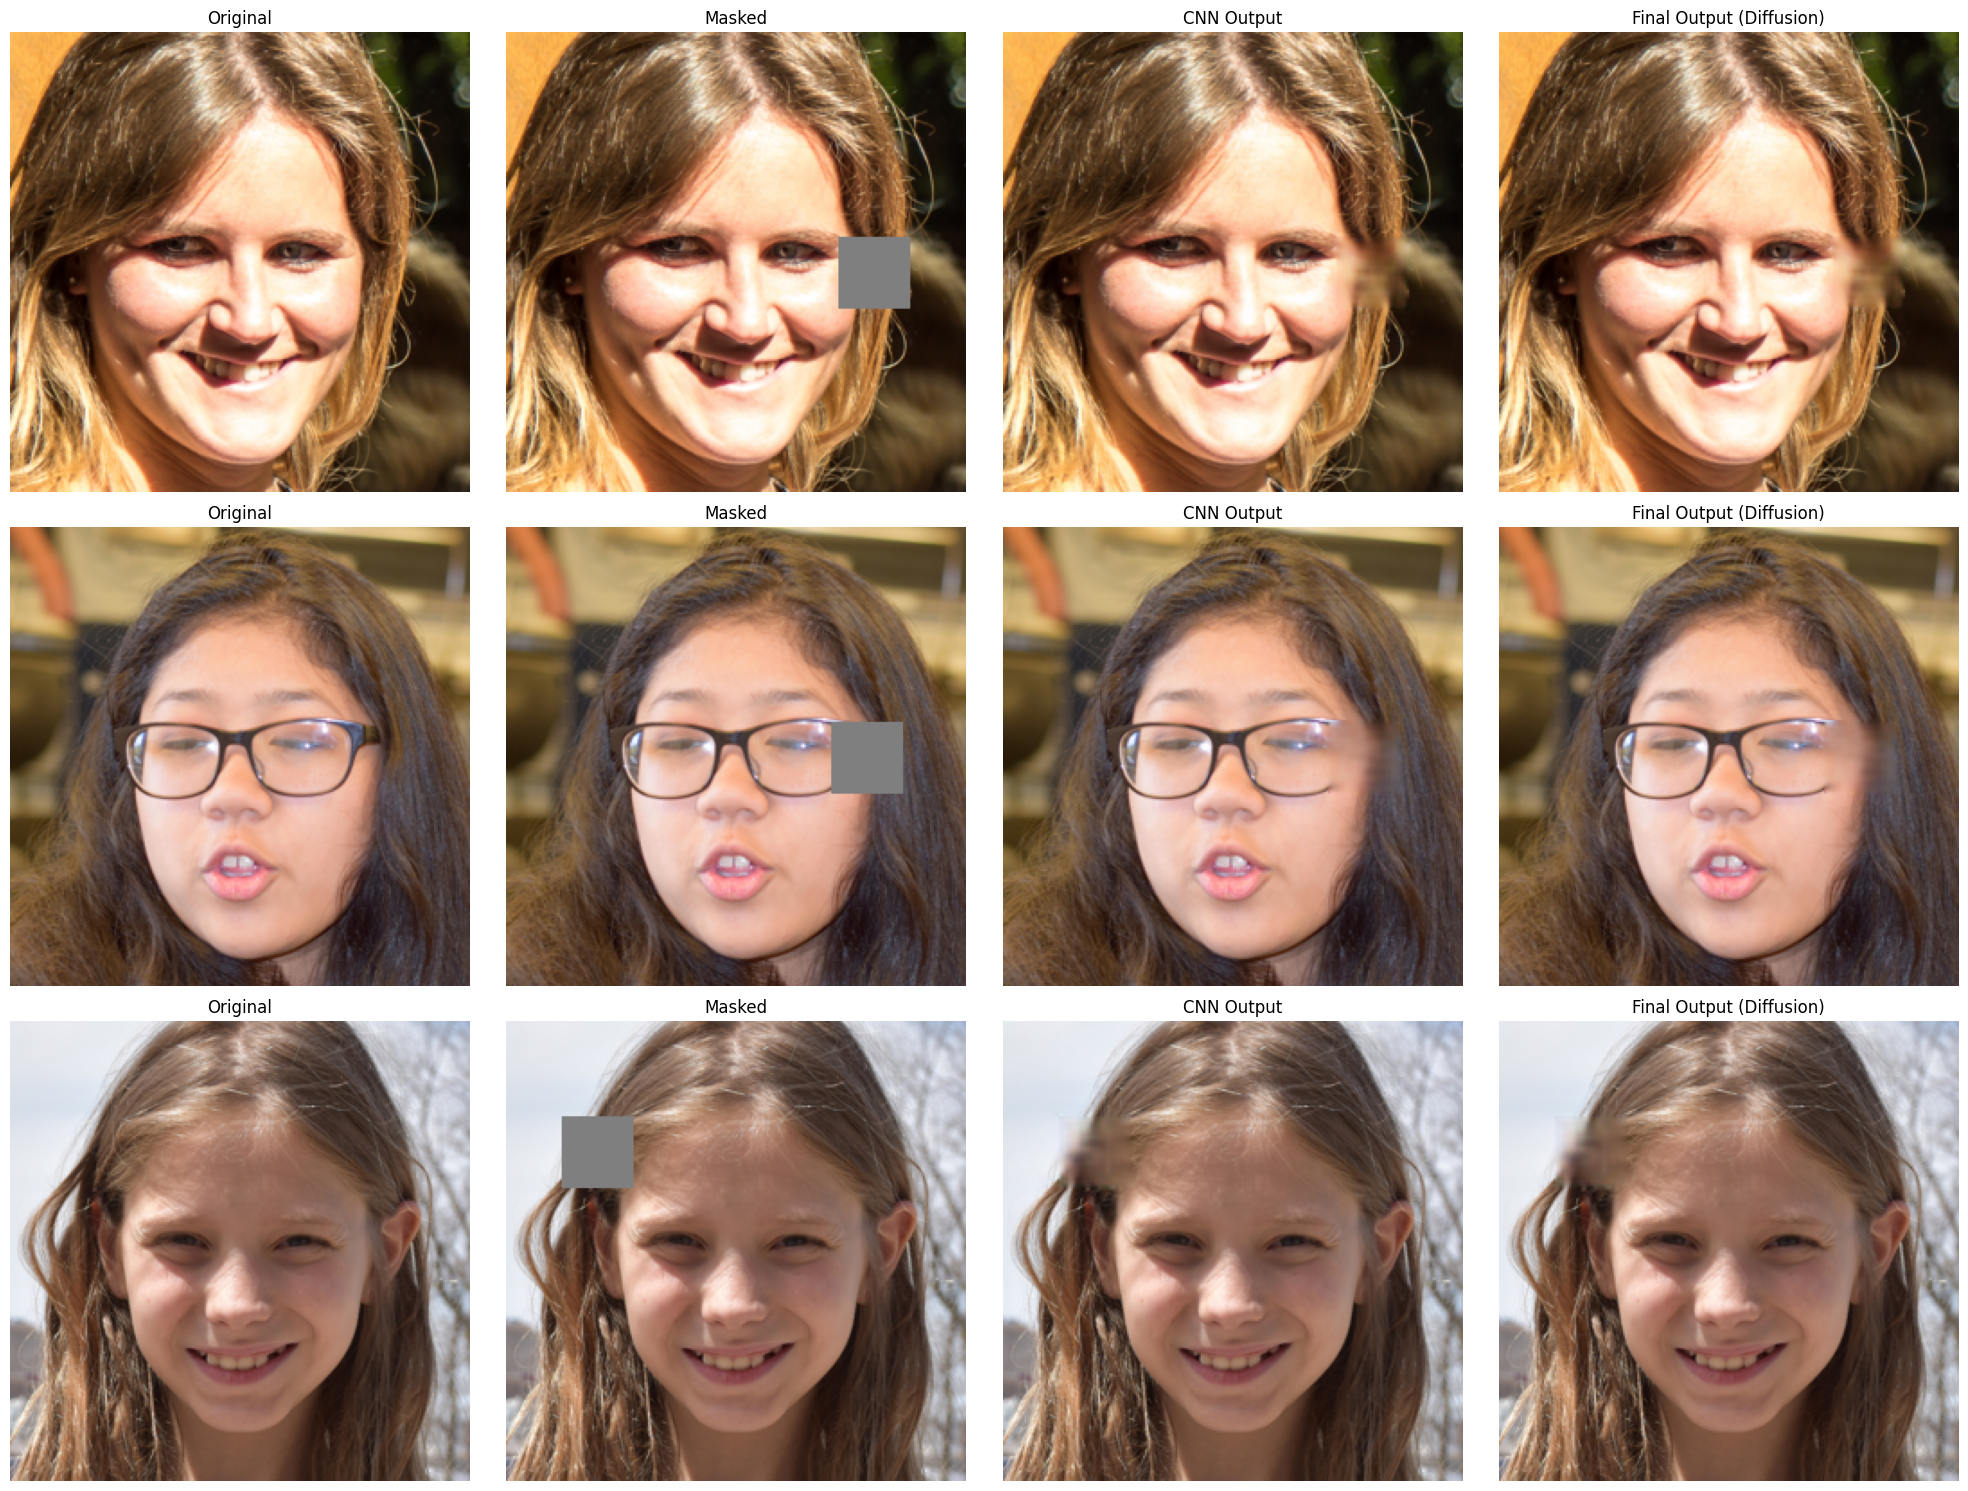

In [ ]:
# --- Final Inference and Visualization with Comprehensive Metrics ---

# Try to import lpips
try:
    import lpips
    lpips_available = True
except:
    print("LPIPS not available. Install with: pip install lpips")
    lpips_available = False

# 1. Initialize your models
print("Initializing models...")
cnn_model = UNetSR(in_channels=4, out_channels=3).to(DEVICE)
diffusion_model = DiffusionUNet(
    in_channels=3,
    model_channels=32,
    time_emb_dim=128
).to(DEVICE)

# --- LOAD WEIGHTS ---
CNN_WEIGHTS_PATH = 'cnn_model_weights.pth'
DIFFUSION_WEIGHTS_PATH = 'diffusion_model_weights.pth'

print(f"Loading weights...")
# Load CNN
cnn_state_dict = torch.load(CNN_WEIGHTS_PATH, map_location=DEVICE)
if any(k.startswith('_orig_mod.') for k in cnn_state_dict.keys()):
    cnn_state_dict = {k.replace('_orig_mod.', ''): v for k, v in cnn_state_dict.items()}
cnn_model.load_state_dict(cnn_state_dict)

# Load Diffusion
diffusion_state_dict = torch.load(DIFFUSION_WEIGHTS_PATH, map_location=DEVICE)
if any(k.startswith('_orig_mod.') for k in diffusion_state_dict.keys()):
    diffusion_state_dict = {k.replace('_orig_mod.', ''): v for k, v in diffusion_state_dict.items()}
diffusion_model.load_state_dict(diffusion_state_dict)

print("✅ All weights loaded successfully.")

# 2. Set models to evaluation mode
cnn_model.eval()
diffusion_model.eval()

# --- Initialize Metrics ---
psnr_metric = torchmetrics.PeakSignalNoiseRatio(data_range=1.0).to(DEVICE)
ssim_metric = torchmetrics.StructuralSimilarityIndexMeasure(data_range=1.0).to(DEVICE)
if lpips_available:
    lpips_metric = lpips.LPIPS(net='alex').to(DEVICE)

# --- Evaluate on Multiple Batches ---
print("\n📊 Evaluating on multiple batches...")
num_eval_batches = 10
all_metrics = {
    'cnn': {'psnr': [], 'ssim': [], 'lpips': [], 'mae': [], 'time': []},
    'diffusion': {'psnr': [], 'ssim': [], 'lpips': [], 'mae': [], 'time': []}
}

eval_dataloader = DataLoader(full_dataset, batch_size=8, shuffle=False)

for batch_idx, batch in enumerate(eval_dataloader):
    if batch_idx >= num_eval_batches:
        break

    original_images = batch.to(DEVICE)

    with torch.no_grad():
        # Create masks
        masked_images, masks = create_mask(original_images, mask_percentage=0.025)
        masks = masks.to(DEVICE)

        # CNN inference with timing
        start_time = time.time()
        cnn_input = torch.cat((masked_images, masks[:, 0:1, :, :]), dim=1)
        coarse_inpainting = cnn_model(cnn_input)
        cnn_time = time.time() - start_time

        # Diffusion inference with timing
        start_time = time.time()
        final_inpainting = sample_diffusion(
            diffusion_model,
            coarse_inpainting,
            original_images,  # Pass original, not masked!
            masks,
            num_timesteps=1000,
            device=DEVICE
        )
        diffusion_time = time.time() - start_time

        # Convert to [0, 1] for metrics
        original_01 = (original_images + 1) / 2
        coarse_01 = (coarse_inpainting + 1) / 2
        final_01 = (final_inpainting + 1) / 2

        # Calculate metrics for CNN
        cnn_psnr = psnr_metric(coarse_01, original_01)
        cnn_ssim = ssim_metric(coarse_01, original_01)
        cnn_mae = F.l1_loss(coarse_01, original_01)

        all_metrics['cnn']['psnr'].append(cnn_psnr.item())
        all_metrics['cnn']['ssim'].append(cnn_ssim.item())
        all_metrics['cnn']['mae'].append(cnn_mae.item())
        all_metrics['cnn']['time'].append(cnn_time)

        if lpips_available:
            cnn_lpips = lpips_metric(coarse_01 * 2 - 1, original_01 * 2 - 1)
            all_metrics['cnn']['lpips'].append(cnn_lpips.mean().item())

        # Calculate metrics for Diffusion
        diff_psnr = psnr_metric(final_01, original_01)
        diff_ssim = ssim_metric(final_01, original_01)
        diff_mae = F.l1_loss(final_01, original_01)

        all_metrics['diffusion']['psnr'].append(diff_psnr.item())
        all_metrics['diffusion']['ssim'].append(diff_ssim.item())
        all_metrics['diffusion']['mae'].append(diff_mae.item())
        all_metrics['diffusion']['time'].append(diffusion_time)

        if lpips_available:
            diff_lpips = lpips_metric(final_01 * 2 - 1, original_01 * 2 - 1)
            all_metrics['diffusion']['lpips'].append(diff_lpips.mean().item())

# --- Print Results ---
print("\n" + "="*60)
print("INPAINTING EVALUATION RESULTS")
print("="*60)

print("\n🔷 CNN MODEL:")
print(f"  PSNR:  {np.mean(all_metrics['cnn']['psnr']):.2f} ± {np.std(all_metrics['cnn']['psnr']):.2f} dB")
print(f"  SSIM:  {np.mean(all_metrics['cnn']['ssim']):.4f} ± {np.std(all_metrics['cnn']['ssim']):.4f}")
print(f"  MAE:   {np.mean(all_metrics['cnn']['mae']):.4f} ± {np.std(all_metrics['cnn']['mae']):.4f}")
if lpips_available:
    print(f"  LPIPS: {np.mean(all_metrics['cnn']['lpips']):.4f} ± {np.std(all_metrics['cnn']['lpips']):.4f}")
print(f"  Time:  {np.mean(all_metrics['cnn']['time']):.3f} ± {np.std(all_metrics['cnn']['time']):.3f} sec")

print("\n🔶 DIFFUSION MODEL (CNN + Diffusion):")
print(f"  PSNR:  {np.mean(all_metrics['diffusion']['psnr']):.2f} ± {np.std(all_metrics['diffusion']['psnr']):.2f} dB")
print(f"  SSIM:  {np.mean(all_metrics['diffusion']['ssim']):.4f} ± {np.std(all_metrics['diffusion']['ssim']):.4f}")
print(f"  MAE:   {np.mean(all_metrics['diffusion']['mae']):.4f} ± {np.std(all_metrics['diffusion']['mae']):.4f}")
if lpips_available:
    print(f"  LPIPS: {np.mean(all_metrics['diffusion']['lpips']):.4f} ± {np.std(all_metrics['diffusion']['lpips']):.4f}")
print(f"  Time:  {np.mean(all_metrics['diffusion']['time']):.3f} ± {np.std(all_metrics['diffusion']['time']):.3f} sec")

print("\n📈 IMPROVEMENT (Diffusion vs CNN):")
print(f"  PSNR:  +{np.mean(all_metrics['diffusion']['psnr']) - np.mean(all_metrics['cnn']['psnr']):.2f} dB")
print(f"  SSIM:  +{np.mean(all_metrics['diffusion']['ssim']) - np.mean(all_metrics['cnn']['ssim']):.4f}")
print(f"  MAE:   {np.mean(all_metrics['diffusion']['mae']) - np.mean(all_metrics['cnn']['mae']):.4f}")
if lpips_available:
    print(f"  LPIPS: {np.mean(all_metrics['diffusion']['lpips']) - np.mean(all_metrics['cnn']['lpips']):.4f}")

# --- Enhanced Visualization ---
print("\n🎨 Generating visualization...")

# Get a fresh batch for visualization
vis_batch = next(iter(eval_dataloader))
vis_images = vis_batch[:6].to(DEVICE)  # Show 6 examples

with torch.no_grad():
    vis_masked, vis_masks = create_mask(vis_images, mask_percentage=0.025)
    vis_masks = vis_masks.to(DEVICE)

    vis_cnn_input = torch.cat((vis_masked, vis_masks[:, 0:1, :, :]), dim=1)
    vis_coarse = cnn_model(vis_cnn_input)

    vis_final = sample_diffusion(
        diffusion_model,
        vis_coarse,
        vis_images,
        vis_masks,
        num_timesteps=1000,
        device=DEVICE
    )

# Create comprehensive visualization
fig = plt.figure(figsize=(20, 18))
fig.suptitle('ResDiff Inpainting Results', fontsize=20, y=0.98)

num_examples = 6
for i in range(num_examples):
    # Original
    plt.subplot(num_examples, 6, i*6 + 1)
    plt.imshow(tensor_to_image(vis_images[i]))
    plt.title("Original", fontsize=12)
    plt.axis('off')

    # Masked
    plt.subplot(num_examples, 6, i*6 + 2)
    plt.imshow(tensor_to_image(vis_masked[i]))
    plt.title("Masked Input", fontsize=12)
    plt.axis('off')

    # CNN Output
    plt.subplot(num_examples, 6, i*6 + 3)
    plt.imshow(tensor_to_image(vis_coarse[i]))
    # Calculate PSNR for this image
    img_psnr = 20 * torch.log10(torch.tensor(1.0)) - 10 * torch.log10(
        F.mse_loss((vis_coarse[i] + 1) / 2, (vis_images[i] + 1) / 2)
    )
    plt.title(f"CNN (PSNR: {img_psnr:.1f})", fontsize=12)
    plt.axis('off')

    # Diffusion Output
    plt.subplot(num_examples, 6, i*6 + 4)
    plt.imshow(tensor_to_image(vis_final[i]))
    # Calculate PSNR for this image
    img_psnr = 20 * torch.log10(torch.tensor(1.0)) - 10 * torch.log10(
        F.mse_loss((vis_final[i] + 1) / 2, (vis_images[i] + 1) / 2)
    )
    plt.title(f"Diffusion (PSNR: {img_psnr:.1f})", fontsize=12)
    plt.axis('off')

    # Difference Map (CNN)
    diff_cnn = torch.abs(vis_images[i] - vis_coarse[i]).mean(dim=0)
    plt.subplot(num_examples, 6, i*6 + 5)
    im = plt.imshow(diff_cnn.cpu().numpy(), cmap='hot', vmin=0, vmax=0.5)
    plt.title("CNN Error", fontsize=12)
    plt.axis('off')
    plt.colorbar(im, ax=plt.gca(), fraction=0.046, pad=0.04)

    # Difference Map (Diffusion)
    diff_final = torch.abs(vis_images[i] - vis_final[i]).mean(dim=0)
    plt.subplot(num_examples, 6, i*6 + 6)
    im = plt.imshow(diff_final.cpu().numpy(), cmap='hot', vmin=0, vmax=0.5)
    plt.title("Diffusion Error", fontsize=12)
    plt.axis('off')
    plt.colorbar(im, ax=plt.gca(), fraction=0.046, pad=0.04)

plt.tight_layout()
plt.savefig('final_results_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

# --- Save Grid Comparison ---
print("\n💾 Saving comparison grids...")

# Create a grid showing progression
grid_images = []
for i in range(4):  # Show 4 examples
    grid_images.extend([
        (vis_images[i] + 1) / 2,
        (vis_masked[i] + 1) / 2,
        (vis_coarse[i] + 1) / 2,
        (vis_final[i] + 1) / 2
    ])

grid = make_grid(grid_images, nrow=4, padding=2, pad_value=1)
save_image(grid, 'inpainting_progression_grid.png')

# --- Zoom-in Comparison ---
print("\n🔍 Creating zoom-in comparison...")

# Focus on masked regions
fig, axes = plt.subplots(3, 4, figsize=(16, 12))
fig.suptitle('Zoom-in on Inpainted Regions', fontsize=16)

for i in range(3):
    # Find mask location
    mask_2d = vis_masks[i, 0].cpu().numpy()
    y_coords, x_coords = np.where(mask_2d == 0)
    if len(y_coords) > 0:
        y_min, y_max = y_coords.min(), y_coords.max()
        x_min, x_max = x_coords.min(), x_coords.max()

        # Add padding
        pad = 10
        y_min = max(0, y_min - pad)
        y_max = min(mask_2d.shape[0], y_max + pad)
        x_min = max(0, x_min - pad)
        x_max = min(mask_2d.shape[1], x_max + pad)

        # Crop all images
        crops = [
            tensor_to_image(vis_images[i])[:, y_min:y_max, x_min:x_max],
            tensor_to_image(vis_masked[i])[:, y_min:y_max, x_min:x_max],
            tensor_to_image(vis_coarse[i])[:, y_min:y_max, x_min:x_max],
            tensor_to_image(vis_final[i])[:, y_min:y_max, x_min:x_max]
        ]

        titles = ['Original', 'Masked', 'CNN', 'Diffusion']
        for j, (crop, title) in enumerate(zip(crops, titles)):
            axes[i, j].imshow(np.transpose(crop, (1, 2, 0)))
            axes[i, j].set_title(title)
            axes[i, j].axis('off')

plt.tight_layout()
plt.savefig('zoom_in_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✅ Evaluation complete! All results saved.")